In [7]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import datetime
from scipy.optimize import curve_fit
import collections
import math

Function to convert CSV files to pandas DataFrame. Discarding the description sentences on top of each file.
'n' refers to the column or the meter that you want to model.

In [8]:
def csv2dataframe(fileName):#csv2dataframe(fileName,n):
    n=1
    newdata=[]
    with open(fileName,'r') as fileData:
        rowData = csv.reader(fileData, 
                           delimiter = ',', 
                           quotechar = '"')
        for data in rowData:
            if len(data)>1:
                newdata.append([data[0],data[n]])                
    data_array = np.asarray(newdata)
    
    return convertDateTime(data_array)

First Column of the array is datetime with 'PST' extension. This function strips timezone and converts it into numpy datetime64 format

In [9]:
def convertDateTime(data_array):
    
    firstCol=data_array[1:,0]
    stripFirstCol=[ele.rstrip(' PST') for ele in firstCol]
    
    dateTimeFirstCol=[np.datetime64(ele) for ele in stripFirstCol]
    data_array[1:,0]=dateTimeFirstCol
    data_frame=pd.DataFrame(data_array.reshape(len(data_array),-1))
    
    data_frame.index=data_frame[0]
    data_frame=data_frame.drop(data_frame.columns[0],axis=1)


    data_frame.columns=data_frame.iloc[0]
    data_frame=data_frame.drop(data_frame.index[0])
    
    data_frame=data_frame.astype(str).astype(float)
    data_frame.index=pd.to_datetime(data_frame.index)
    data_frame=data_frame.resample('15T').mean()
    data_frame=data_frame[1:]
    return data_frame

In [10]:
reactivePfile='R3_12_47_1_AMI_residential_phase12_reactive_power.csv'
realPfile='R3_12_47_1_AMI_residential_phase12_real_power.csv'
reactiveVfile='R3_12_47_1_AMI_residential_phase12_reactive_voltage.csv'
realVfile='R3_12_47_1_AMI_residential_phase12_real_voltage.csv'
temperaturefile='R3_12_47_1_climate.csv'

In [11]:
reactiveP=csv2dataframe(reactivePfile)
realP=csv2dataframe(realPfile)
reactiveV=csv2dataframe(reactiveVfile)
realV=csv2dataframe(realVfile)
amiTemp=csv2dataframe(temperaturefile)

Given a startDate and endDate for a season, this function generates all the dates within that interval. This dateList is later used to find the weekdays and weekends within that interval

In [12]:
def getDateList(startDate,endDate):
    startDate=datetime.datetime.strptime(startDate,'%Y-%m-%d')

    endDate=datetime.datetime.strptime(endDate,'%Y-%m-%d')
  
    numDays=endDate-startDate
    numDays=numDays.days

    date_list = [startDate + datetime.timedelta(days=x) for x in range(0, numDays)]
    return date_list

def splitWDWE(data_frame,weekdays,weekends):
    weekdayResult=getDays(data_frame,weekdays)
    weekendResult=getDays(data_frame,weekends)
    return weekdayResult, weekendResult

This function extracts only those instance from the data_frame that match in 'days'. Days is either the list of weekdays or weekends

In [13]:
def getDays(data_frame,days):
    result=data_frame[days[0]]
    for i in range(1,len(days)):
            result=result.append(data_frame[days[i]])
    return result

This function return the instances for a given hourwindow. If the 'hourwindow' is 1, then it extracts only those instances whose hour in the index is equal to 'hr'. If the 'hourwindow' is greater than 1, then it return all those instance which match the hours in the range 'hr' to 'hr+hourwindow'

In [14]:
def getHourData(data_frame,hourwindow,hr):
    if hourwindow==1:
        result=data_frame[data_frame.index.hour == hr]
    else:
        result=data_frame[data_frame.index.hour == hr]
        for i in range(1,hourwindow):
            hr=hr+i
            result=result.append(data_frame[data_frame.index.hour == hr])
            
    return result

This is the function/modelthe curve_fit function would take to find the coefficients.

In [15]:
def myfunc(independentVar, a, b, c):
    x,t=independentVar
    return (a*(x)**2)+b*x+c   #+t - the r squared value is negative when we include temperature
                                # is this a linear or non linear model?
                                

def realFunc(independentVar,Z,I,P, Zo,Io,Po):
    x,t,S=independentVar
    return (((x**2)*S*Z*(math.cos(Zo)))+(x*S*I*(math.cos(Io)))+(S*P*(math.cos(Po)))+t)

def reactiveFunc(independentVar,Z,I,P, Zo,Io,Po):
    x,t,S=independentVar
    return (((x**2)*S*Z*(math.sin(Zo)))+(x*S*I*(math.sin(Io)))+(S*P*(math.sin(Po)))+t)

Function to calculate the Root Mean Square Error value

In [16]:
def RMS(yActual, yPredicted):
    squares = (yPredicted - yActual) ** 2
    result=(sum(squares)/len(yActual))**(0.5)
    return result

In [17]:
def rSquared(x, yActual, yPredicted):
    squareError = (yPredicted - yActual) ** 2
    variationFromMean= (yActual - yActual.mean()) ** 2
    result = 1 - (sum(squareError)/sum(variationFromMean))
    return result
    

Finds the Nominal Power when the nominal Voltage is between a certain range. voltageSensitivity allows to change the range within which we can set the nominalVoltage to be.

In [18]:
def getNominalPower(apparentPower, apparentVoltage):#getNominalPower(apparentPower, apparentVoltage, voltageSensitivity):
    voltageSensitivity=3;
    nominalV=apparentVoltage.mean()
    powerArray=[]
    
    for i in range(0,len(apparentPower)):
        
        if ((apparentVoltage.iloc[i].values>= (nominalV-voltageSensitivity)).bool() | (apparentVoltage.iloc[i].values <= (nominalV+voltageSensitivity)).bool()):
            powerArray.extend(apparentPower.iloc[i].values)
    
    return np.mean(powerArray) # or np.median(powerArray)
    

The coefficients that we get from curve fitting is a profuct of nominalPower(Sn), Z/I/P coefficient and cos or sin of Z/I/P angle for real or reactive Power respectively. This function tries to get the Z, I, P coefficient values from the product.

In [19]:
def processCoefficients(coefficient1, coefficient2, nominalPower):
    coefficient1=coefficient1/nominalPower
    coefficient2=coefficient2/nominalPower
    
    for i in range(0,len(coefficient1)):
            coefficient1[i],coefficient2[i]= splitCoefficient(coefficient1[i],coefficient2[i])
    
    return coefficient1, coefficient2

In [20]:
def splitCoefficient(coefficient1, coefficient2):
    theta=math.atan(coefficient2/coefficient1)
    coefficient1=coefficient1/(math.cos(theta))
    coefficient2=coefficient2/(math.sin(theta))
    return coefficient1, coefficient2

TODO- need to create a function that would take the starting and ending date from the dataset and then create seasonDate ranges

In [21]:
seasonDates=['2013-01-01','2013-03-01','2013-05-15']

hourWindows over which the coefficients are to be computed. '1' refers to finding coefficients for every hour of the day, while '24' refers to finding coefficients over the entire day.

'1' would compute {4(numOfSeasons) * 2(weekdays,weekends) * 24 (each hour in a day)} efficients
'12' would compute {4(numOfSeasons) * 2(weekdays,weekends) * 2 (12 hour window of each day)} efficients
'24' would compute {4(numOfSeasons) * 2(weekdays,weekends) * 1 (considers the entire day)} efficients

In [22]:
hourWindows=[1,2,4,8,12,24]

Find the Coefficients and RMSE values for different time windows, based on Season, Weekday, Weekend and Hourly

HOUR WINDOW IS 1
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 1


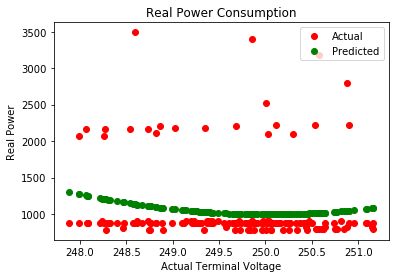

R SQUARED VALUES is 0.0195436498297


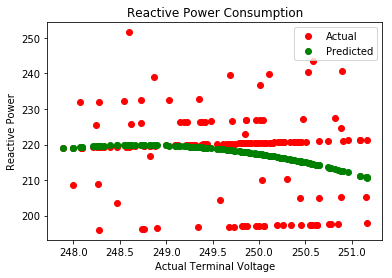

R SQUARED VALUES is 0.0407326562587
1 to 2


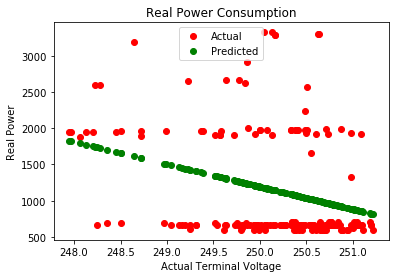

R SQUARED VALUES is 0.0932744117519


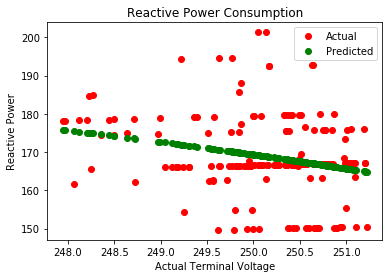

R SQUARED VALUES is 0.057741473295
2 to 3


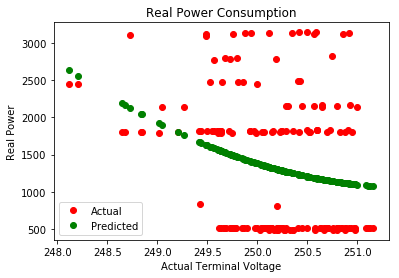

R SQUARED VALUES is 0.0788010495095


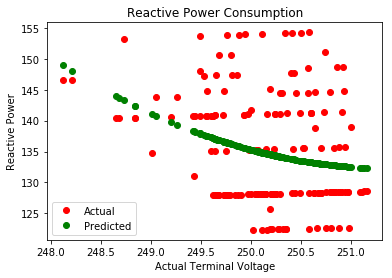

R SQUARED VALUES is 0.0886569168589
3 to 4


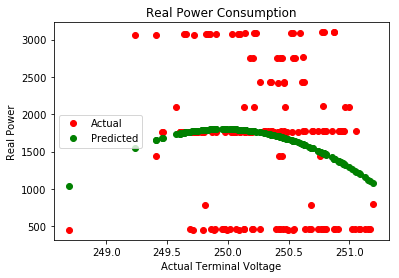

R SQUARED VALUES is 0.0426969820707


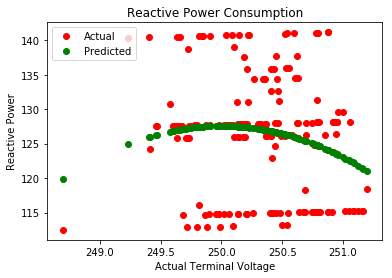

R SQUARED VALUES is 0.0351309327581
4 to 5


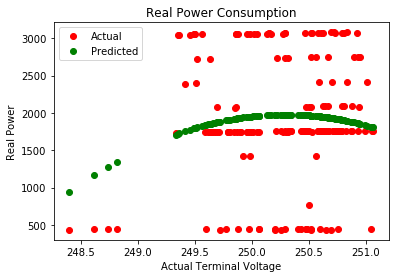

R SQUARED VALUES is 0.0239785336758


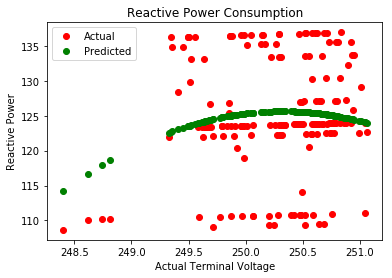

R SQUARED VALUES is 0.0298009386473
5 to 6


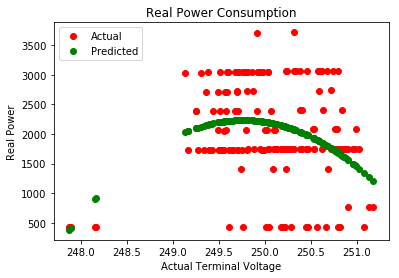

R SQUARED VALUES is 0.144297170093


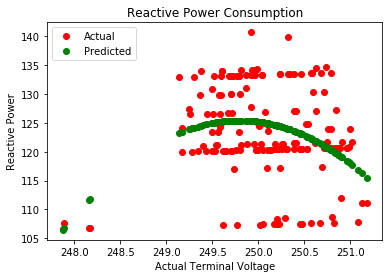

R SQUARED VALUES is 0.143624819573
6 to 7


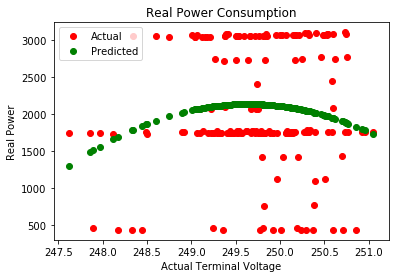

R SQUARED VALUES is 0.0268506413124


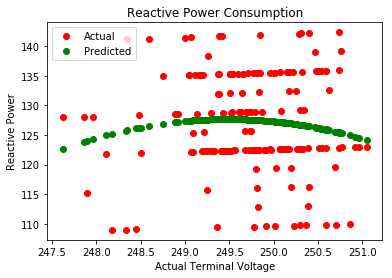

R SQUARED VALUES is 0.0117428465802
7 to 8


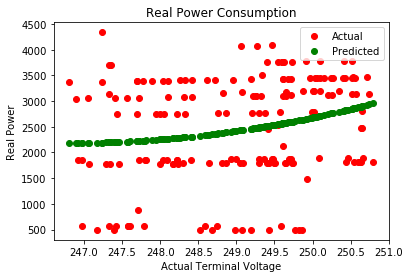

R SQUARED VALUES is 0.0482073981388


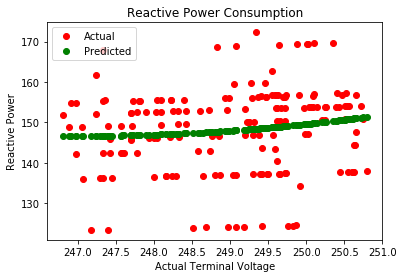

R SQUARED VALUES is 0.0173240205537
8 to 9


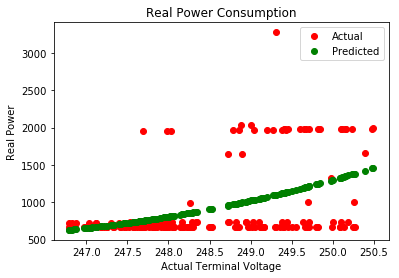

R SQUARED VALUES is 0.194830249429


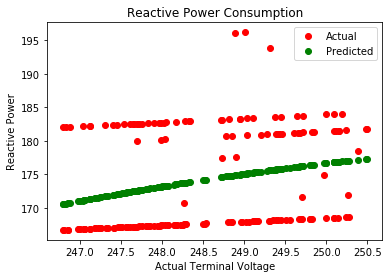

R SQUARED VALUES is 0.0637010764985
9 to 10


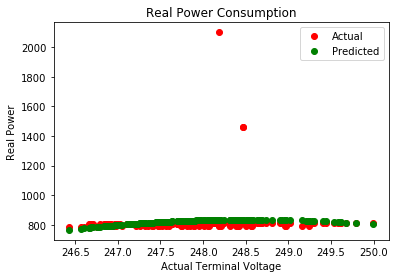

R SQUARED VALUES is 0.0170182405006


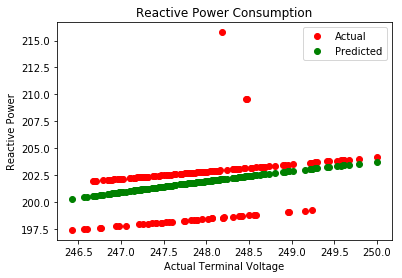

R SQUARED VALUES is 0.0969222634234
10 to 11


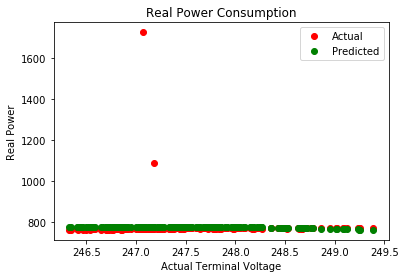

R SQUARED VALUES is 0.00217090298592


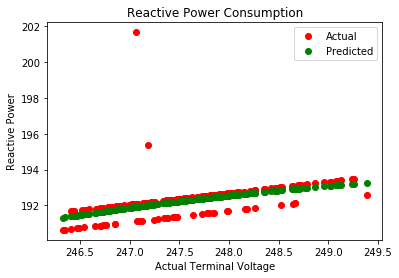

R SQUARED VALUES is 0.222183944904
11 to 12


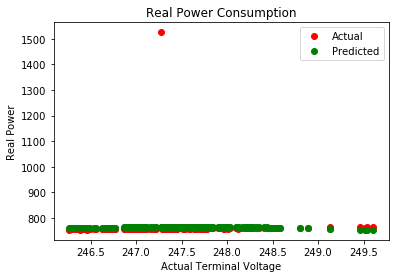

R SQUARED VALUES is 0.0012420617456


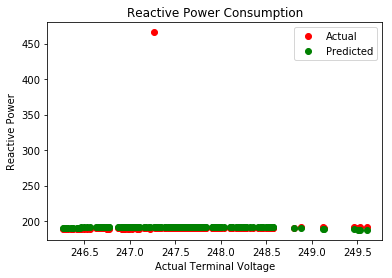

R SQUARED VALUES is 0.00137145950913
12 to 13


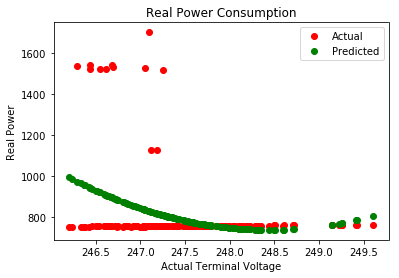

R SQUARED VALUES is 0.112458331005


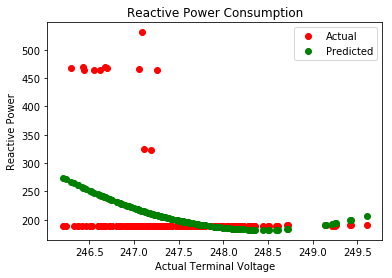

R SQUARED VALUES is 0.113194239743
13 to 14


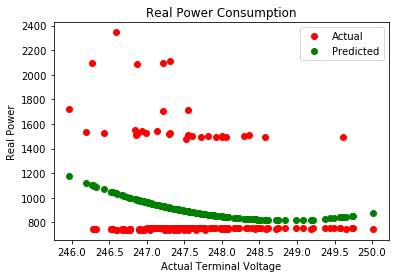

R SQUARED VALUES is 0.0436120710191


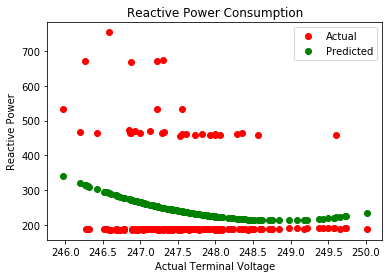

R SQUARED VALUES is 0.0429634520028
14 to 15


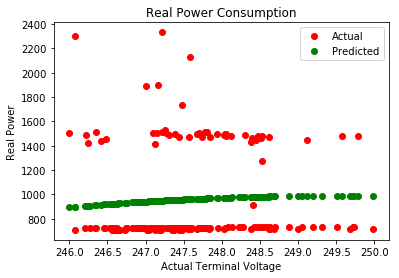

R SQUARED VALUES is 0.00355035364838


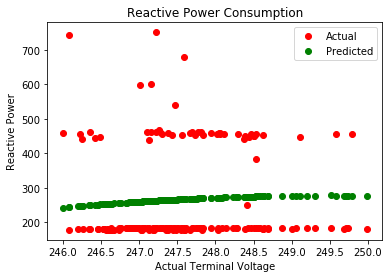

R SQUARED VALUES is 0.00379673361789
15 to 16


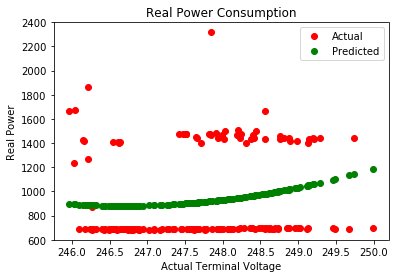

R SQUARED VALUES is 0.0268594324302


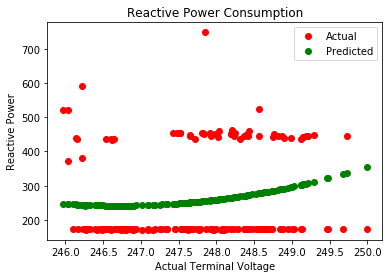

R SQUARED VALUES is 0.0277009701251
16 to 17


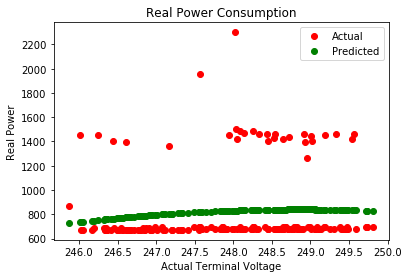

R SQUARED VALUES is 0.0091505397308


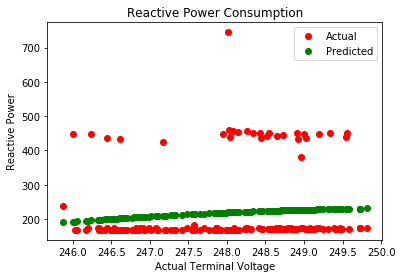

R SQUARED VALUES is 0.0100227771762
17 to 18


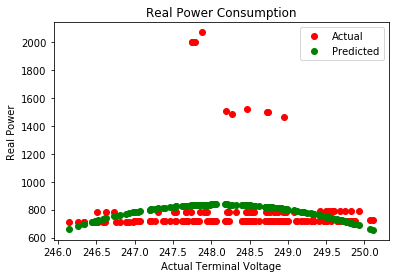

R SQUARED VALUES is 0.038633608452


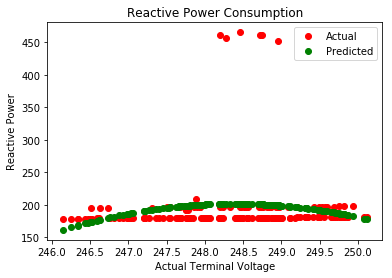

R SQUARED VALUES is 0.0282038420443
18 to 19


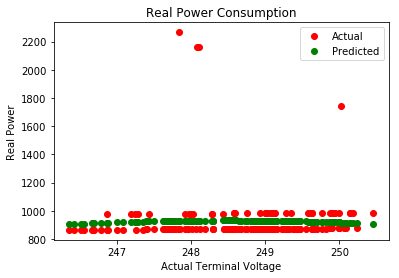

R SQUARED VALUES is 0.00105010521609


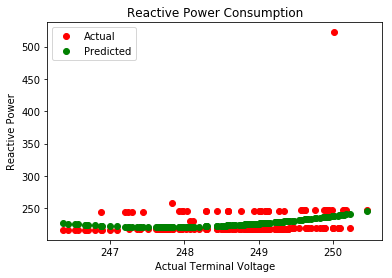

R SQUARED VALUES is 0.0475037018222
19 to 20


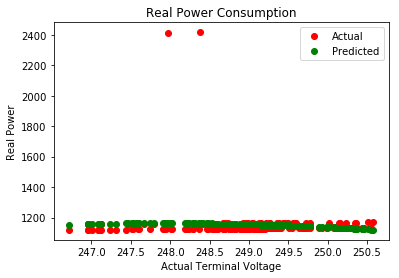

R SQUARED VALUES is 0.00677654777375


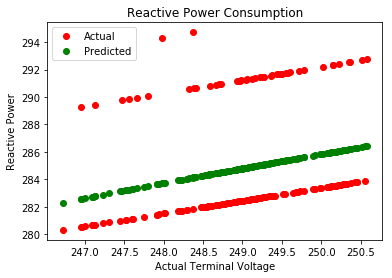

R SQUARED VALUES is 0.0553731856643
20 to 21


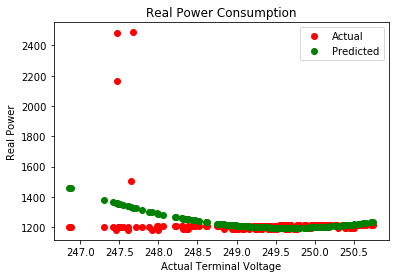

R SQUARED VALUES is 0.103687939304


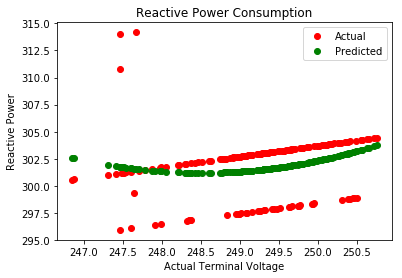

R SQUARED VALUES is 0.0484897927896
21 to 22


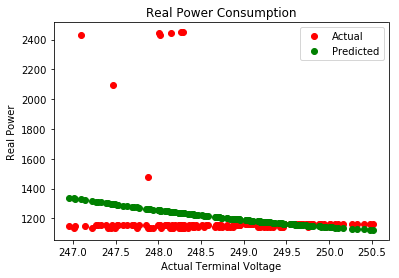

R SQUARED VALUES is 0.0437863163802


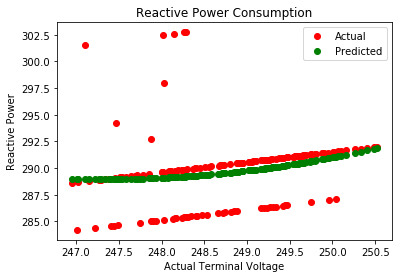

R SQUARED VALUES is 0.046768234597
22 to 23


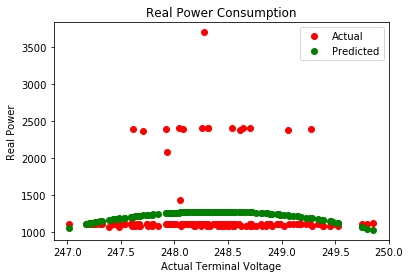

R SQUARED VALUES is 0.0197092836131


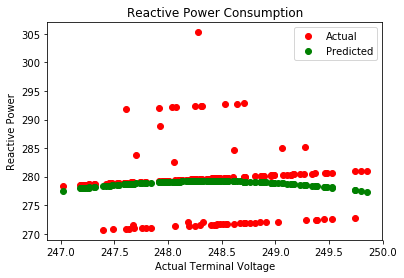

R SQUARED VALUES is 0.00659295223103
23 to 24


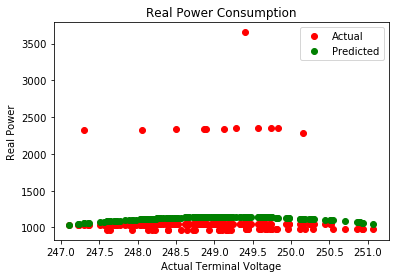

R SQUARED VALUES is 0.00452235057192


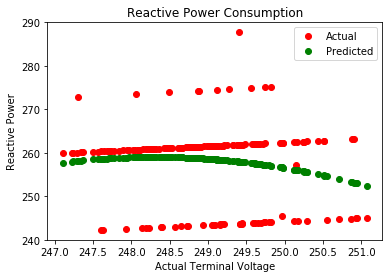

R SQUARED VALUES is 0.0250950595352
Weekends
0 to 1


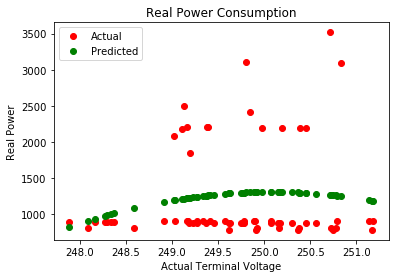

R SQUARED VALUES is 0.0253838077041


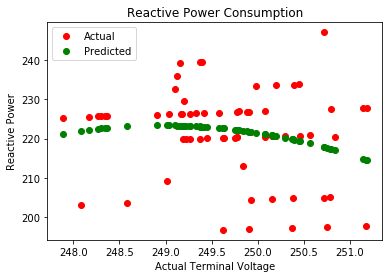

R SQUARED VALUES is 0.0396993724875
1 to 2


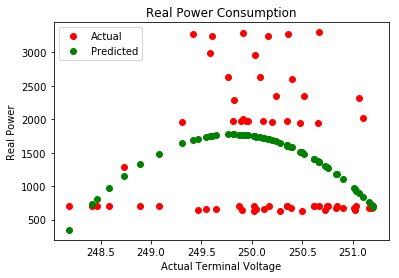

R SQUARED VALUES is 0.148845424986


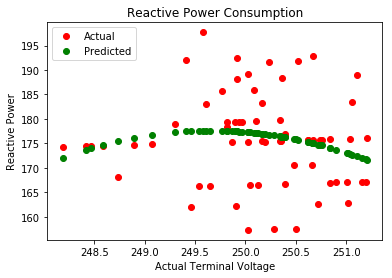

R SQUARED VALUES is 0.0364243052268
2 to 3


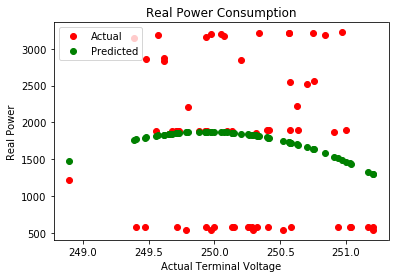

R SQUARED VALUES is 0.0238347495018


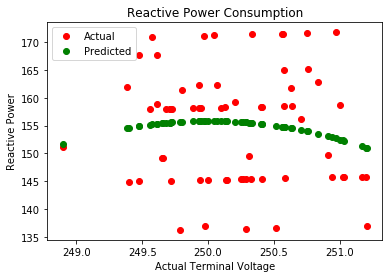

R SQUARED VALUES is 0.016481350213
3 to 4


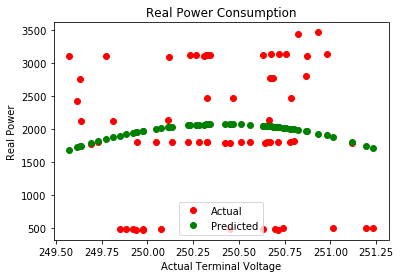

R SQUARED VALUES is 0.0117269773876


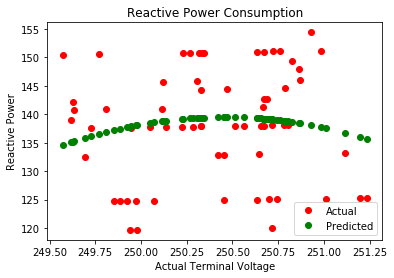

R SQUARED VALUES is 0.0181632873812
4 to 5


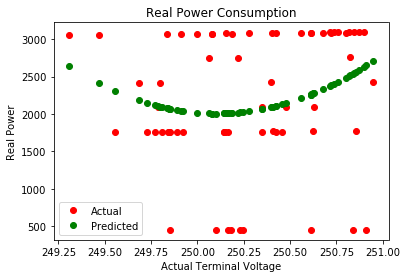

R SQUARED VALUES is 0.0536885849282


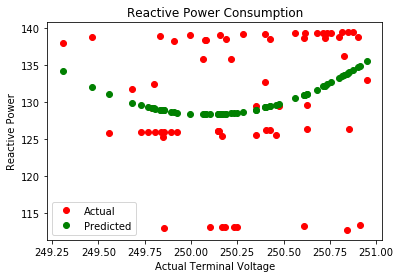

R SQUARED VALUES is 0.05723440292
5 to 6


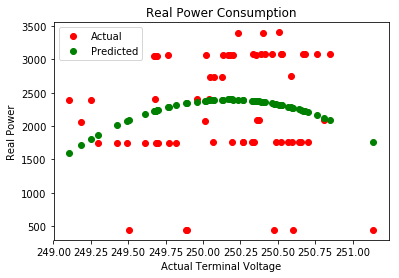

R SQUARED VALUES is 0.0460461651118


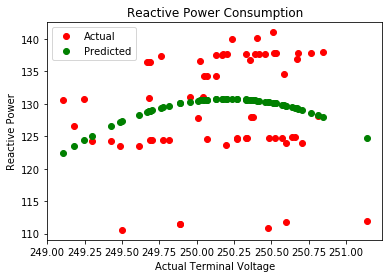

R SQUARED VALUES is 0.0509423808746
6 to 7


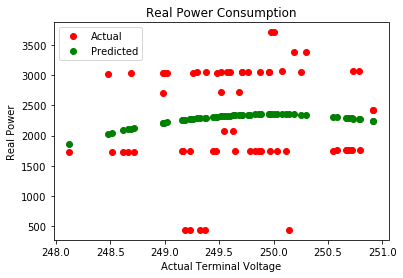

R SQUARED VALUES is 0.0129339180457


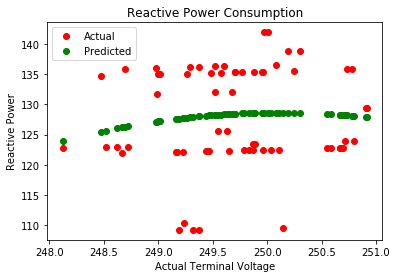

R SQUARED VALUES is 0.0120004967085
7 to 8


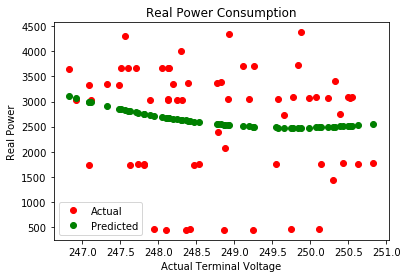

R SQUARED VALUES is 0.0218569857386


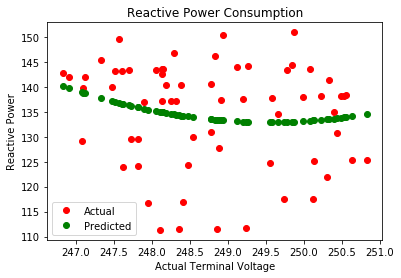

R SQUARED VALUES is 0.0302880190833
8 to 9


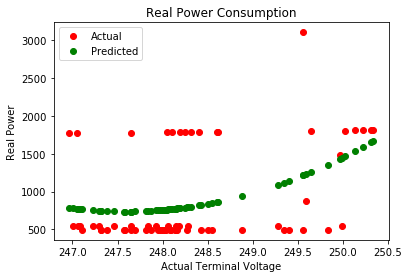

R SQUARED VALUES is 0.180002217434


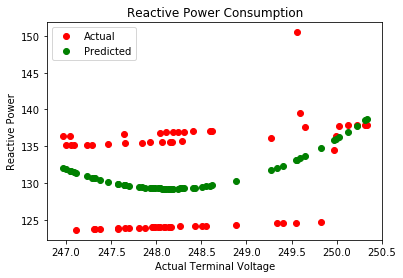

R SQUARED VALUES is 0.144902513225
9 to 10


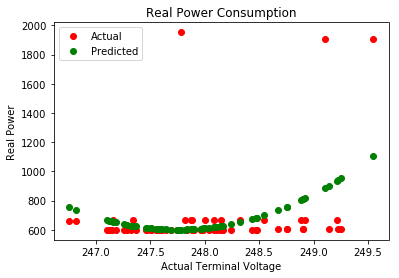

R SQUARED VALUES is 0.151624598781


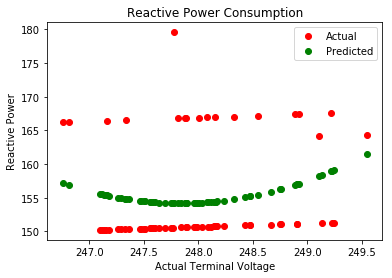

R SQUARED VALUES is 0.0405115346011
10 to 11


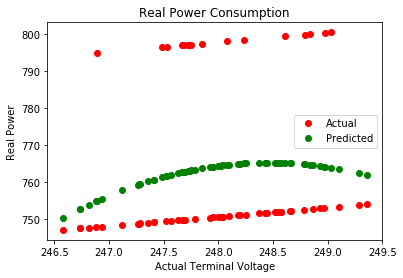

R SQUARED VALUES is 0.0297998763959


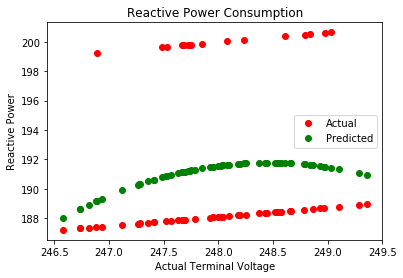

R SQUARED VALUES is 0.0297998790428
11 to 12


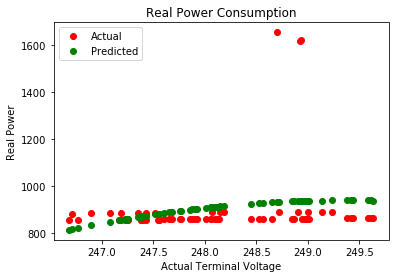

R SQUARED VALUES is 0.0453452741357


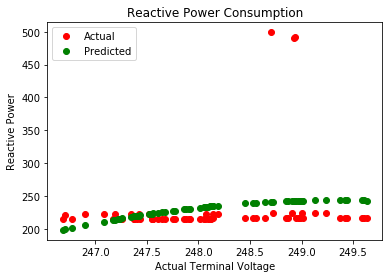

R SQUARED VALUES is 0.0449340516642
12 to 13


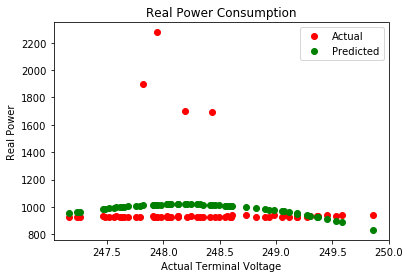

R SQUARED VALUES is 0.0254182785054


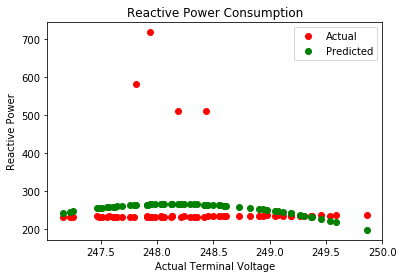

R SQUARED VALUES is 0.0261908902587
13 to 14


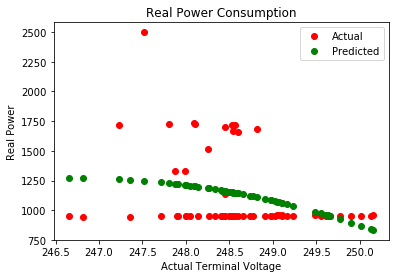

R SQUARED VALUES is 0.108639193374


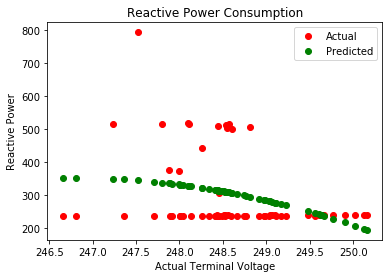

R SQUARED VALUES is 0.109279328563
14 to 15


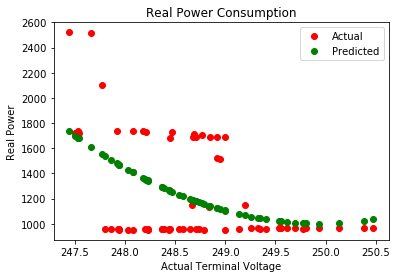

R SQUARED VALUES is 0.245461557816


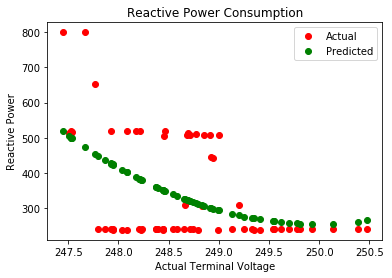

R SQUARED VALUES is 0.242207330632
15 to 16


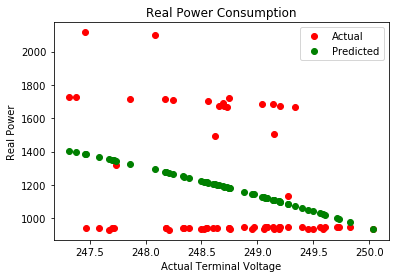

R SQUARED VALUES is 0.0968729358211


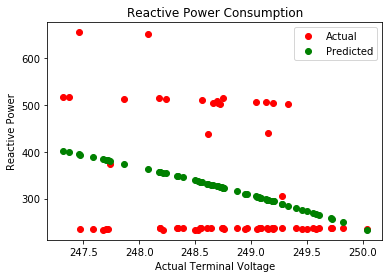

R SQUARED VALUES is 0.0945336197594
16 to 17


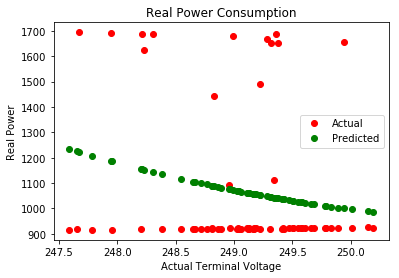

R SQUARED VALUES is 0.0418437415063


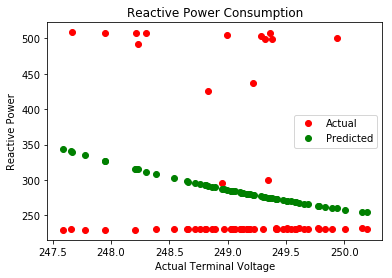

R SQUARED VALUES is 0.0414054526655
17 to 18


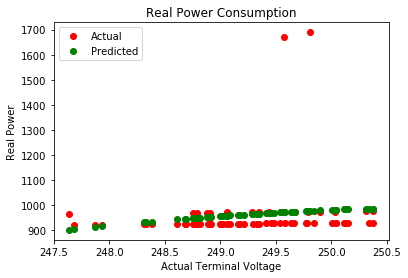

R SQUARED VALUES is 0.0222548384902


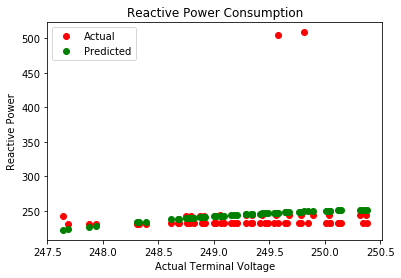

R SQUARED VALUES is 0.0200090276577
18 to 19


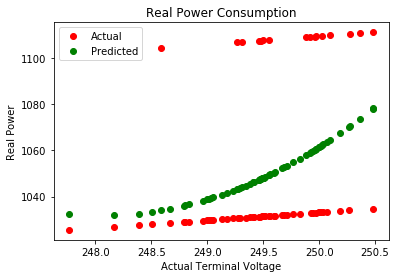

R SQUARED VALUES is 0.117989429218


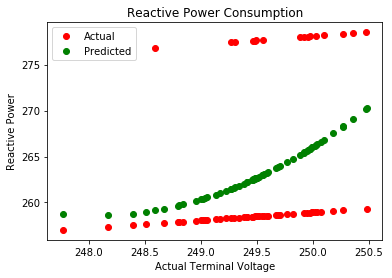

R SQUARED VALUES is 0.117989431749
19 to 20


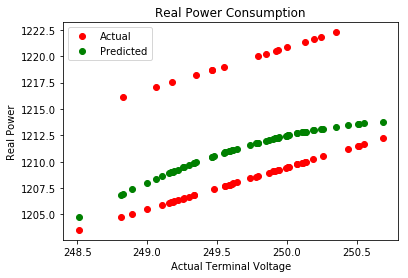

R SQUARED VALUES is 0.136560682265


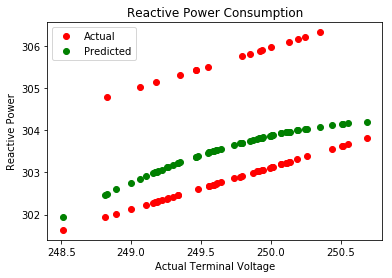

R SQUARED VALUES is 0.136560706756
20 to 21


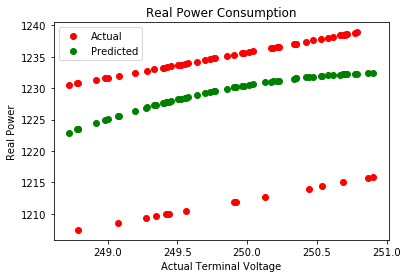

R SQUARED VALUES is 0.064510791529


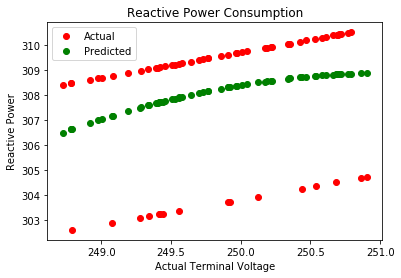

R SQUARED VALUES is 0.0645107927698
21 to 22


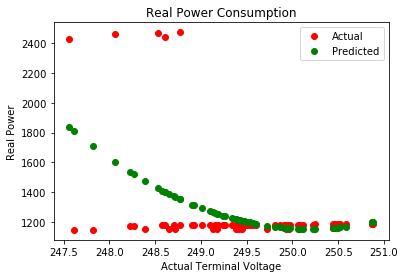

R SQUARED VALUES is 0.203662048101


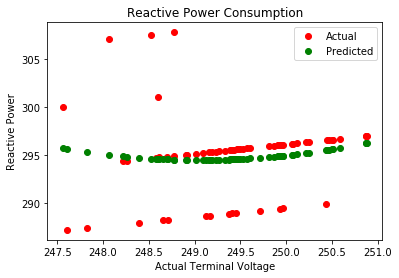

R SQUARED VALUES is 0.0126806801698
22 to 23


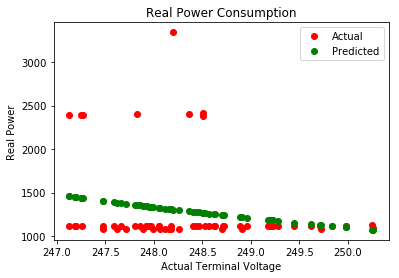

R SQUARED VALUES is 0.0470612041528


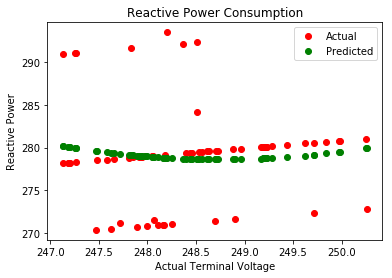

R SQUARED VALUES is 0.0074029460521
23 to 24


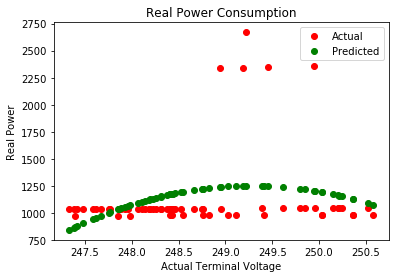

R SQUARED VALUES is 0.0831949020717


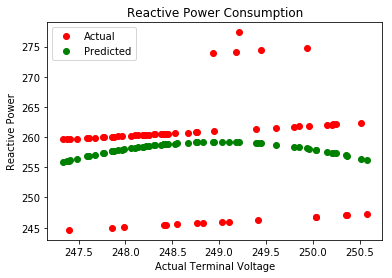

R SQUARED VALUES is 0.0143484512972
Season  2
2013-03-01
2013-05-15
Weekdays
0 to 1


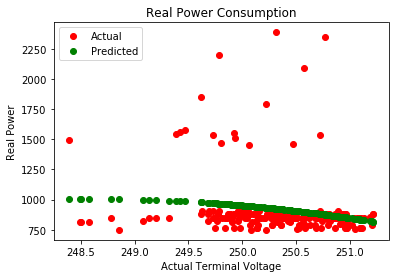

R SQUARED VALUES is 0.0326567689066


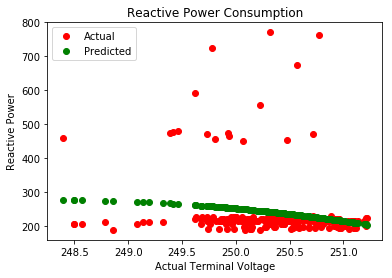

R SQUARED VALUES is 0.0323311746196
1 to 2


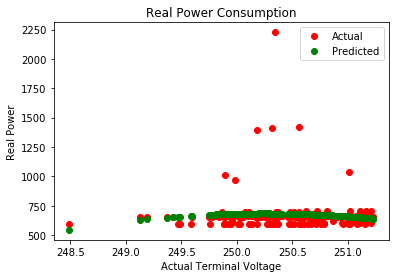

R SQUARED VALUES is 0.0108769104621


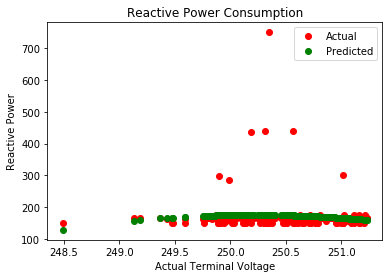

R SQUARED VALUES is 0.0103910950744
2 to 3


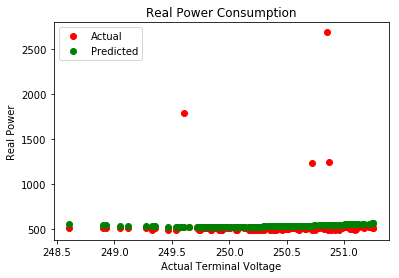

R SQUARED VALUES is 0.00324225492861


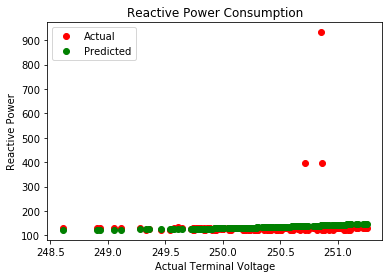

R SQUARED VALUES is 0.0106396595343
3 to 4


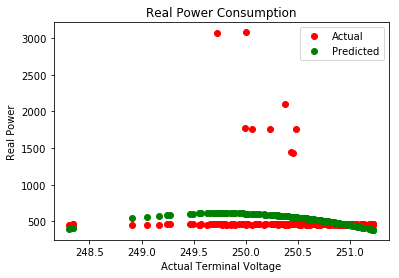

R SQUARED VALUES is 0.0379815944279


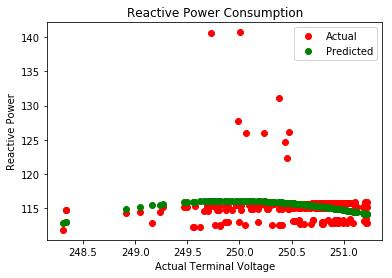

R SQUARED VALUES is 0.0329570043172
4 to 5


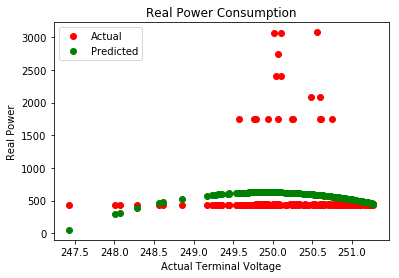

R SQUARED VALUES is 0.0189518369367


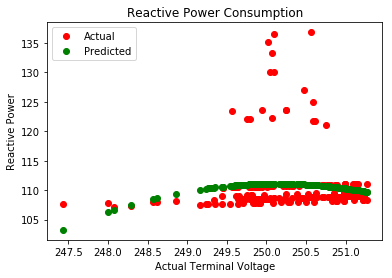

R SQUARED VALUES is 0.0242797452063
5 to 6


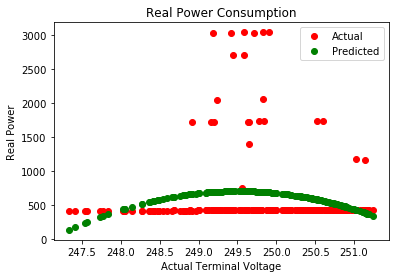

R SQUARED VALUES is 0.0421624723037


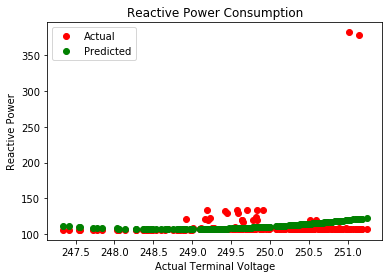

R SQUARED VALUES is 0.028706609069
6 to 7


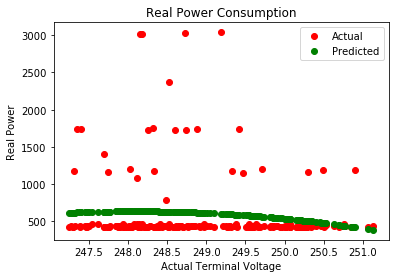

R SQUARED VALUES is 0.0161954656781


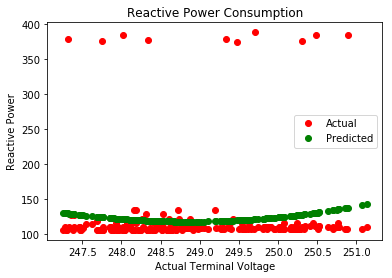

R SQUARED VALUES is 0.00762376830458
7 to 8


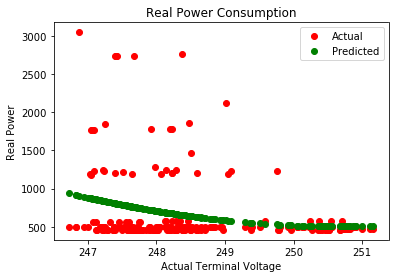

R SQUARED VALUES is 0.0579747983075


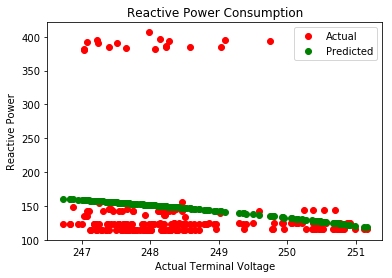

R SQUARED VALUES is 0.0221469898531
8 to 9


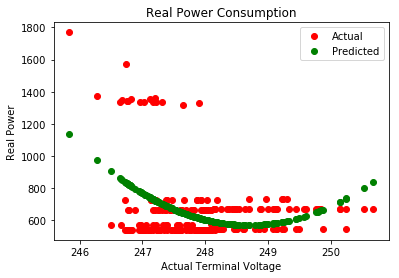

R SQUARED VALUES is 0.165857512725


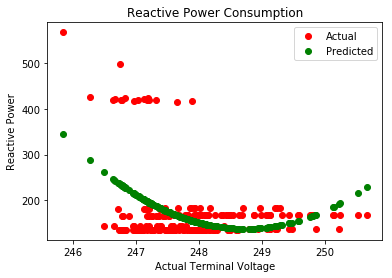

R SQUARED VALUES is 0.179670544304
9 to 10


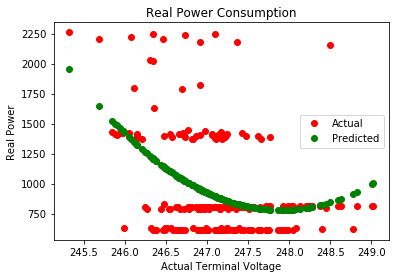

R SQUARED VALUES is 0.192811942235


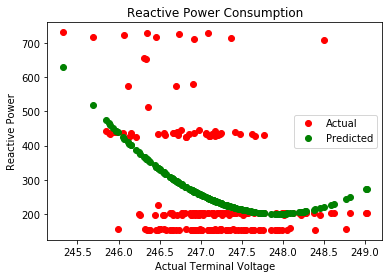

R SQUARED VALUES is 0.198584588079
10 to 11


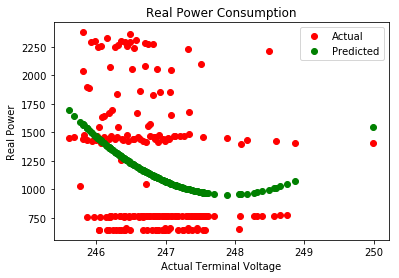

R SQUARED VALUES is 0.103368121832


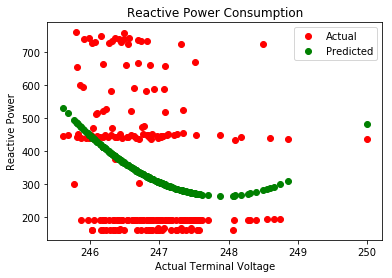

R SQUARED VALUES is 0.104410527131
11 to 12


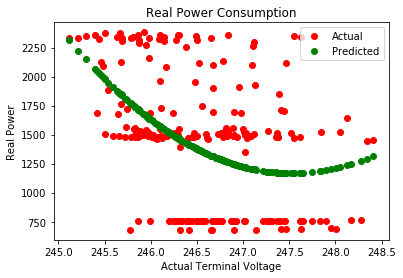

R SQUARED VALUES is 0.196934672104


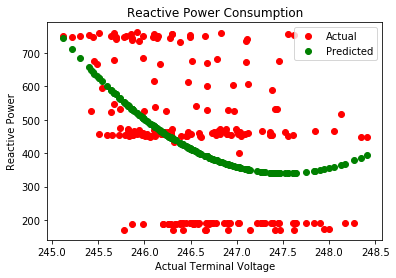

R SQUARED VALUES is 0.194367043151
12 to 13


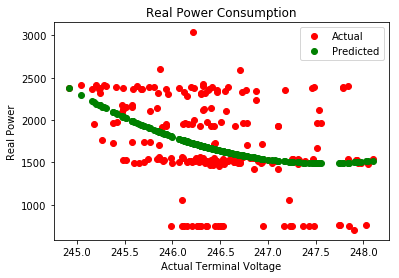

R SQUARED VALUES is 0.13874636163


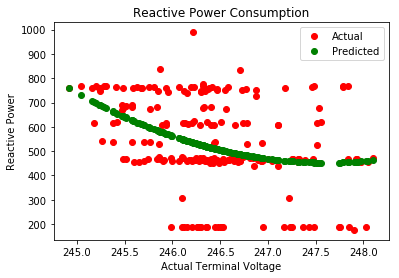

R SQUARED VALUES is 0.134091778679
13 to 14


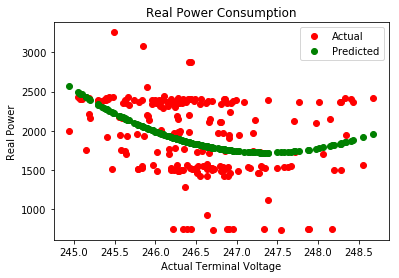

R SQUARED VALUES is 0.145949299687


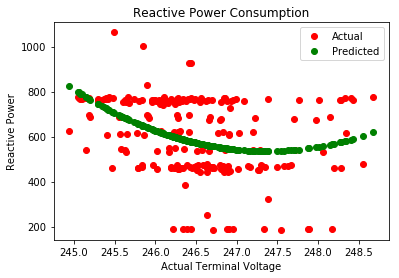

R SQUARED VALUES is 0.139769198033
14 to 15


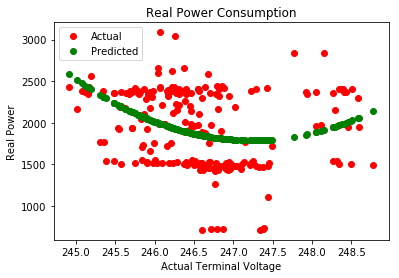

R SQUARED VALUES is 0.11404747599


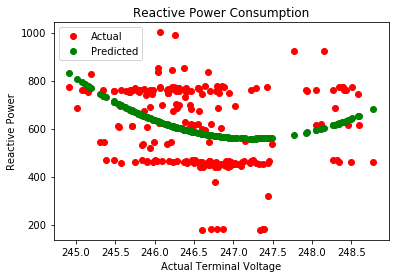

R SQUARED VALUES is 0.111344378583
15 to 16


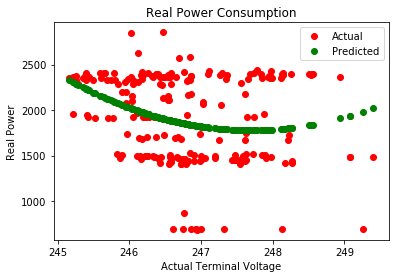

R SQUARED VALUES is 0.0748071972681


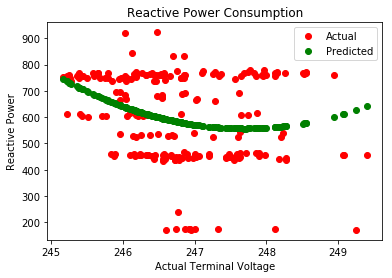

R SQUARED VALUES is 0.072574355904
16 to 17


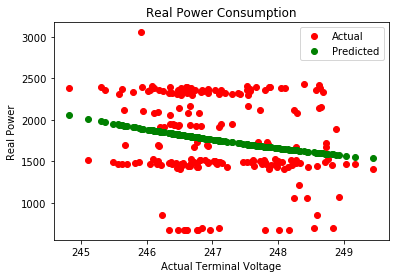

R SQUARED VALUES is 0.0400778459493


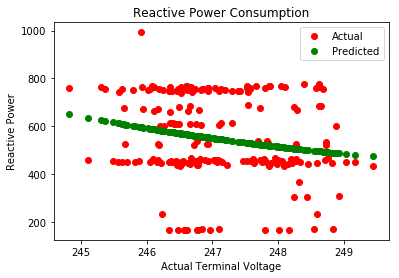

R SQUARED VALUES is 0.0381208037185
17 to 18


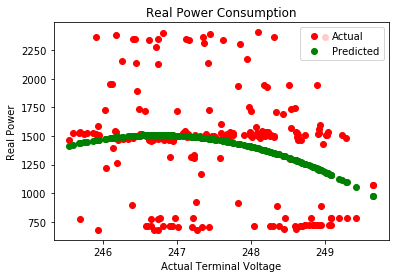

R SQUARED VALUES is 0.0640943043656


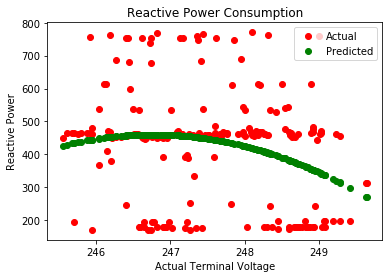

R SQUARED VALUES is 0.0646960117201
18 to 19


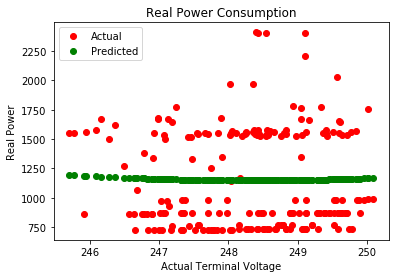

R SQUARED VALUES is 0.000371413620838


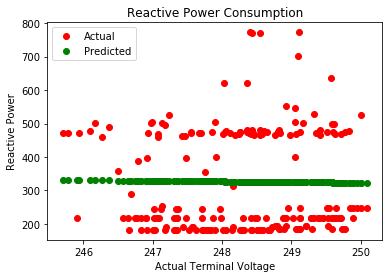

R SQUARED VALUES is 0.000169595900526
19 to 20


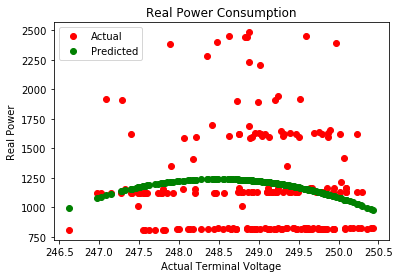

R SQUARED VALUES is 0.0220745911893


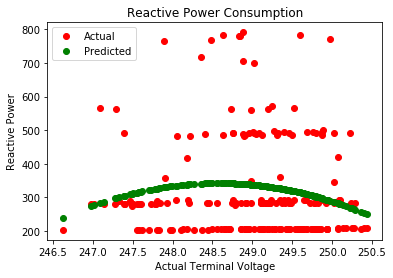

R SQUARED VALUES is 0.0227044539692
20 to 21


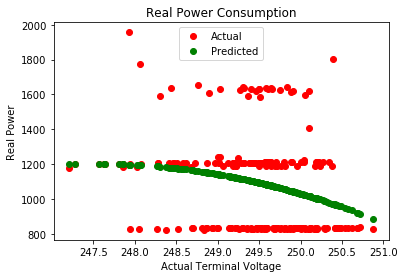

R SQUARED VALUES is 0.0597548486651


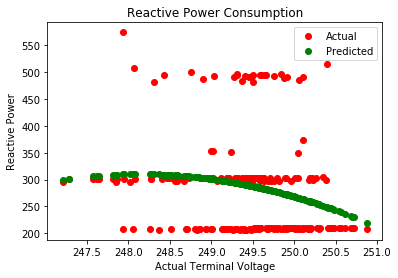

R SQUARED VALUES is 0.0434960186131
21 to 22


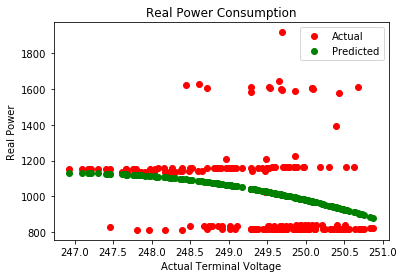

R SQUARED VALUES is 0.0691007195865


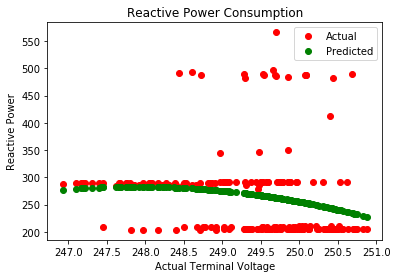

R SQUARED VALUES is 0.0308819864647
22 to 23


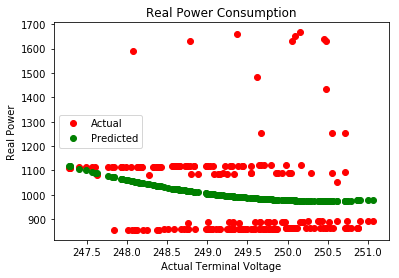

R SQUARED VALUES is 0.0349858067366


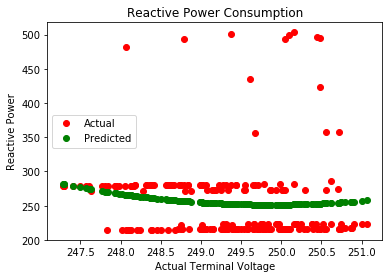

R SQUARED VALUES is 0.0117486644349
23 to 24


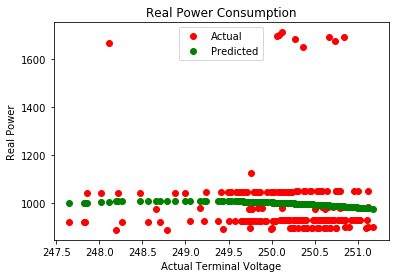

R SQUARED VALUES is 0.00309388307666


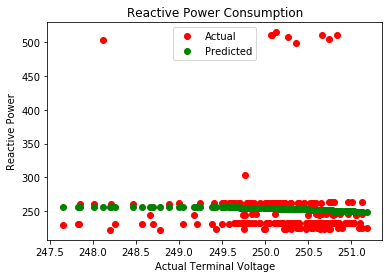

R SQUARED VALUES is 0.00141180391261
Weekends
0 to 1


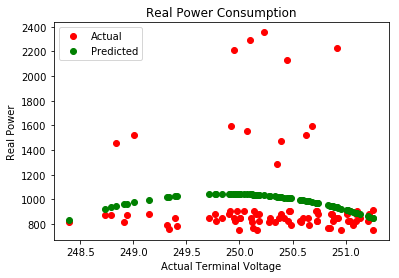

R SQUARED VALUES is 0.0252130966309


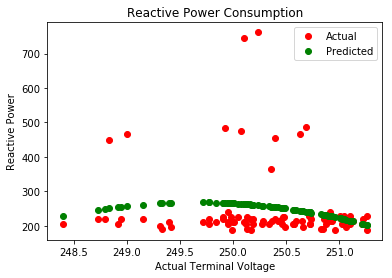

R SQUARED VALUES is 0.0313502820001
1 to 2


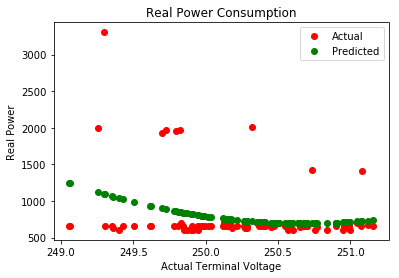

R SQUARED VALUES is 0.0828004948961


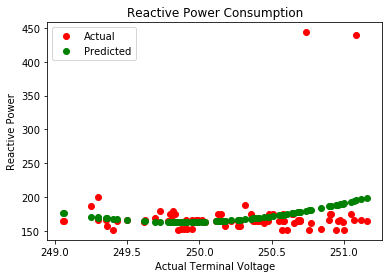

R SQUARED VALUES is 0.0536854025249
2 to 3


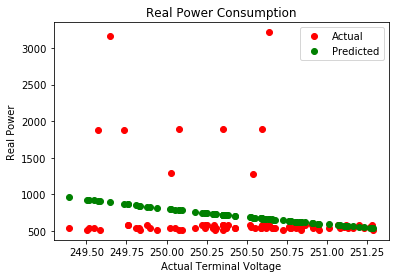

R SQUARED VALUES is 0.0439543123019


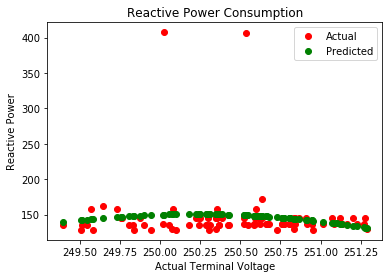

R SQUARED VALUES is 0.0153710050891
3 to 4


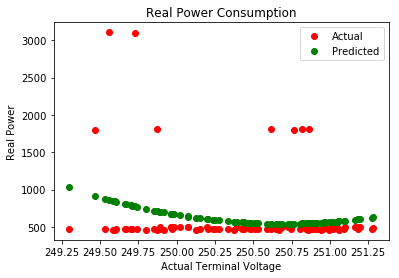

R SQUARED VALUES is 0.0452649227699


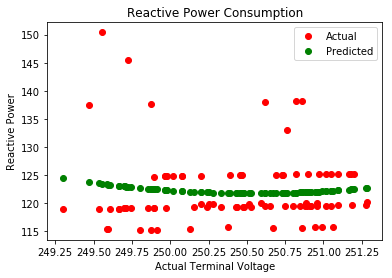

R SQUARED VALUES is 0.00677643134259
4 to 5


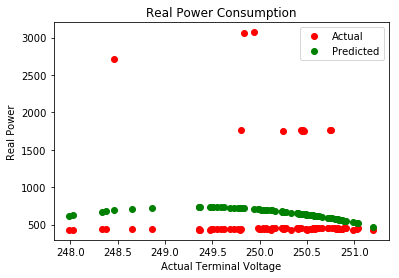

R SQUARED VALUES is 0.012263409024


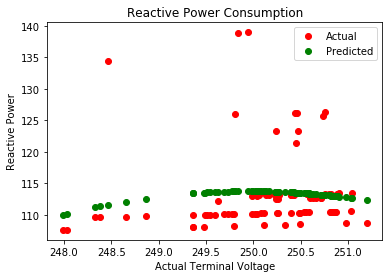

R SQUARED VALUES is 0.012404946286
5 to 6


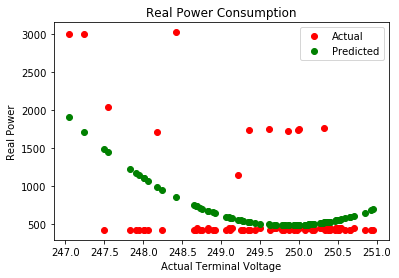

R SQUARED VALUES is 0.222708553222


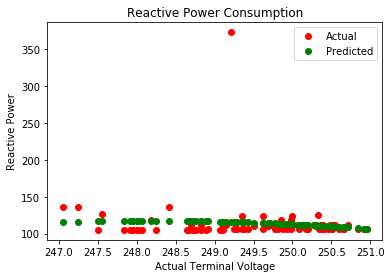

R SQUARED VALUES is 0.0106749449156
6 to 7


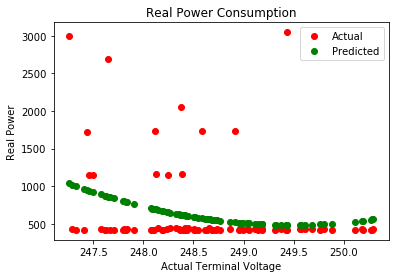

R SQUARED VALUES is 0.0709665803411


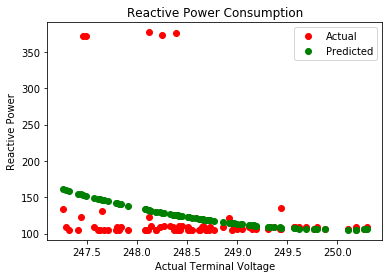

R SQUARED VALUES is 0.0599147969525
7 to 8


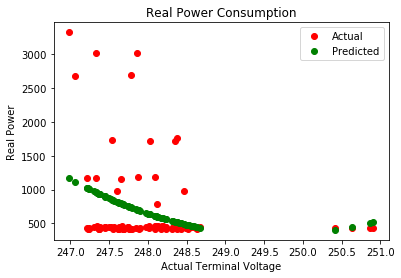

R SQUARED VALUES is 0.0855973938261


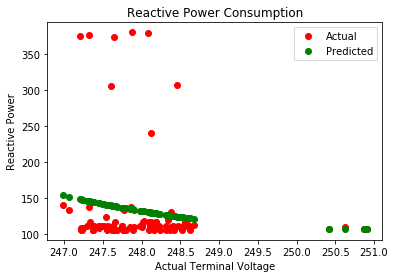

R SQUARED VALUES is 0.0216338356047
8 to 9


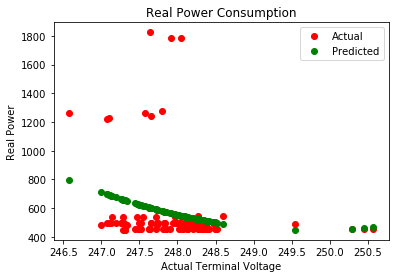

R SQUARED VALUES is 0.0484760942909


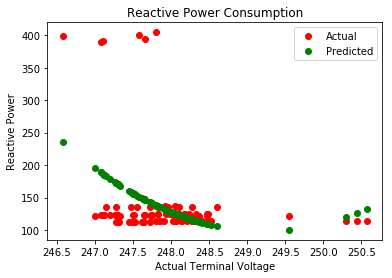

R SQUARED VALUES is 0.136608881313
9 to 10


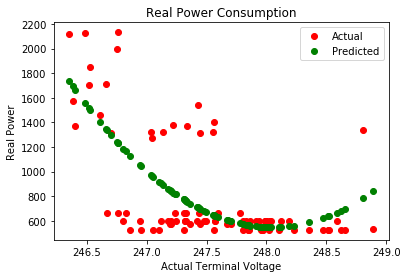

R SQUARED VALUES is 0.473867632066


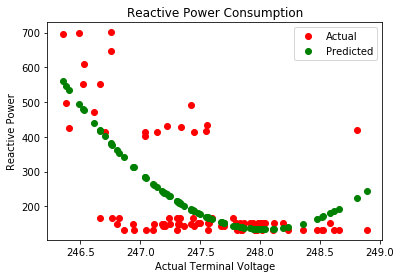

R SQUARED VALUES is 0.471861219461
10 to 11


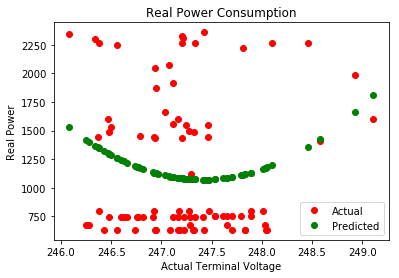

R SQUARED VALUES is 0.0512058595528


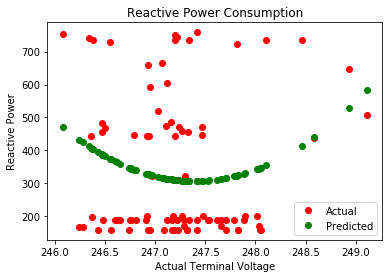

R SQUARED VALUES is 0.0542328866683
11 to 12


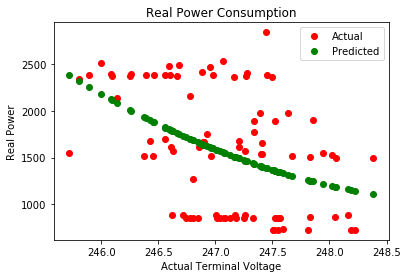

R SQUARED VALUES is 0.19487498766


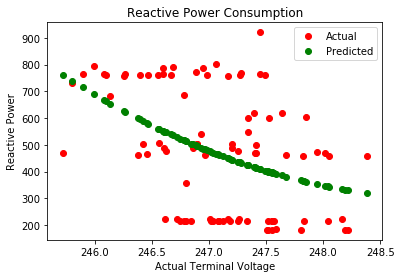

R SQUARED VALUES is 0.185762501445
12 to 13


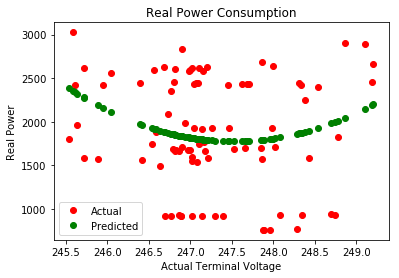

R SQUARED VALUES is 0.0589651874981


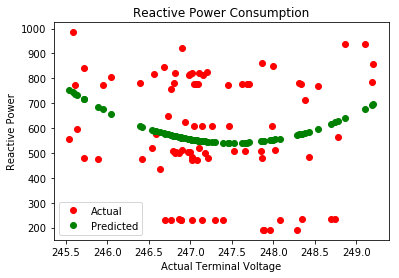

R SQUARED VALUES is 0.059183761922
13 to 14


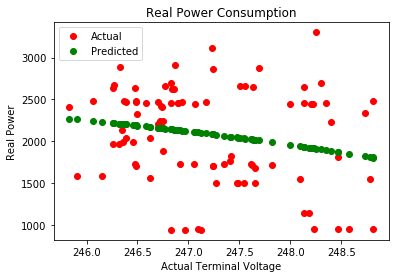

R SQUARED VALUES is 0.0438719935085


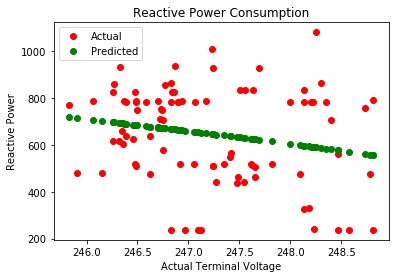

R SQUARED VALUES is 0.0417103992848
14 to 15


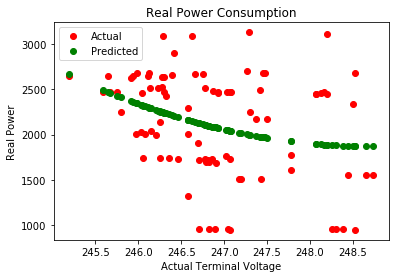

R SQUARED VALUES is 0.0929340595914


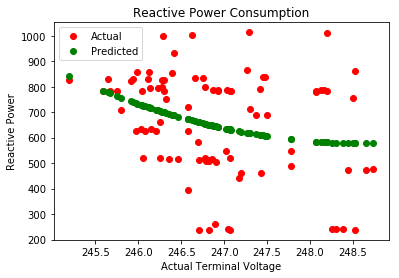

R SQUARED VALUES is 0.0845068083093
15 to 16


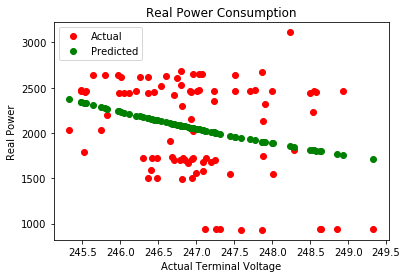

R SQUARED VALUES is 0.0771871610826


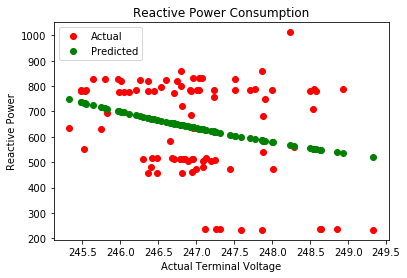

R SQUARED VALUES is 0.0741852601259
16 to 17


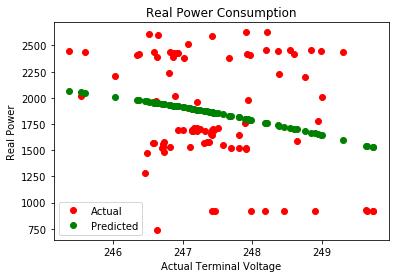

R SQUARED VALUES is 0.0526512549985


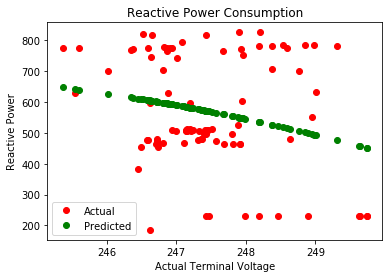

R SQUARED VALUES is 0.0564200451909
17 to 18


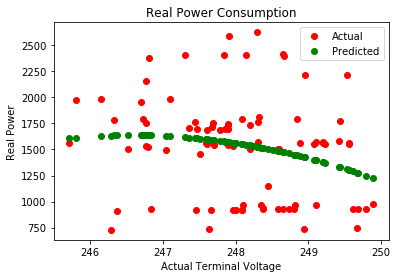

R SQUARED VALUES is 0.0511439098038


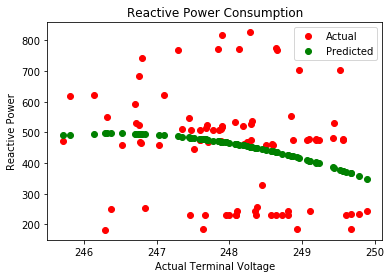

R SQUARED VALUES is 0.0516975529198
18 to 19


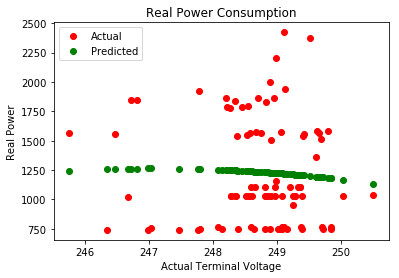

R SQUARED VALUES is 0.00298504293472


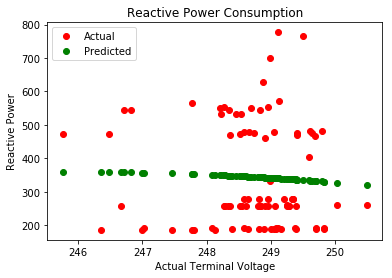

R SQUARED VALUES is 0.00240288992787
19 to 20


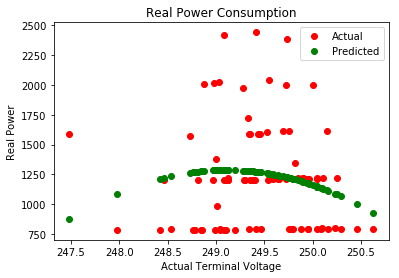

R SQUARED VALUES is 0.0352795018086


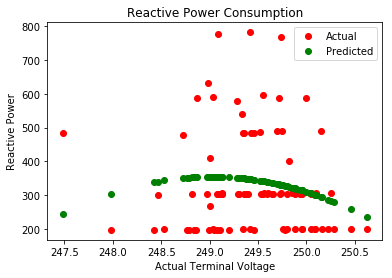

R SQUARED VALUES is 0.0301280546128
20 to 21


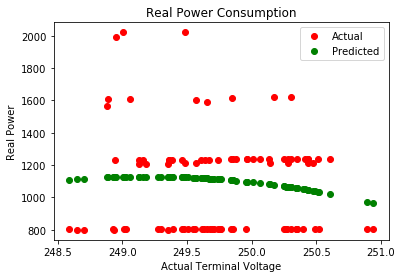

R SQUARED VALUES is 0.0130994923609


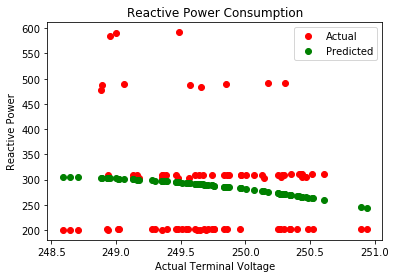

R SQUARED VALUES is 0.019659810983
21 to 22


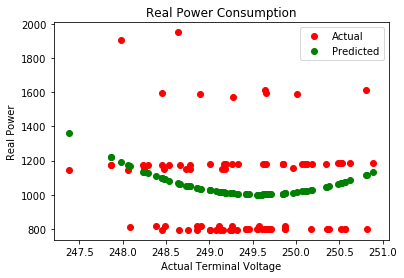

R SQUARED VALUES is 0.0500421484061


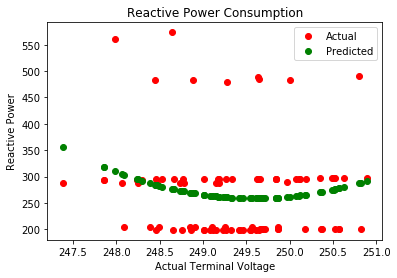

R SQUARED VALUES is 0.0343254942602
22 to 23


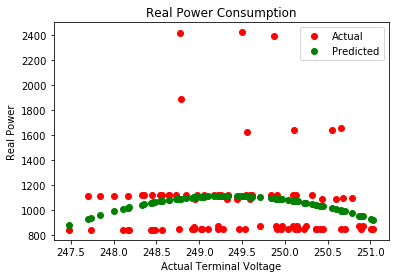

R SQUARED VALUES is 0.0281598707506


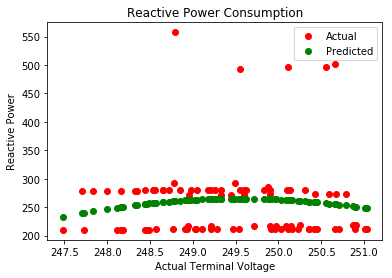

R SQUARED VALUES is 0.00901506569124
23 to 24


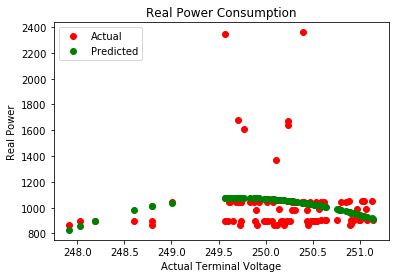

R SQUARED VALUES is 0.0446511560614


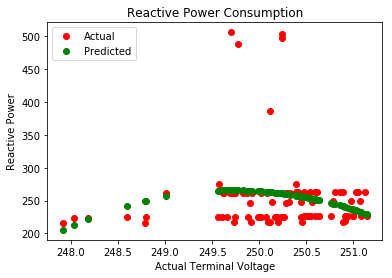

R SQUARED VALUES is 0.0478297351253
HOUR WINDOW IS 2
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 2


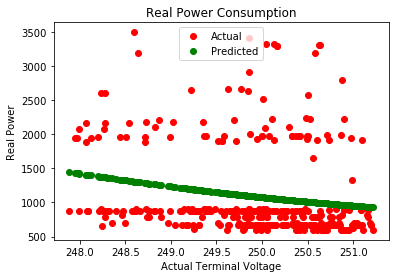

R SQUARED VALUES is 0.0351663184153


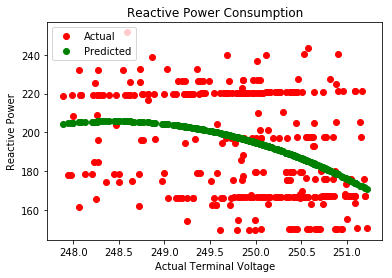

R SQUARED VALUES is 0.126591010294
2 to 4


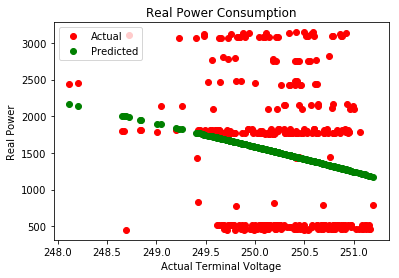

R SQUARED VALUES is 0.0364381903423


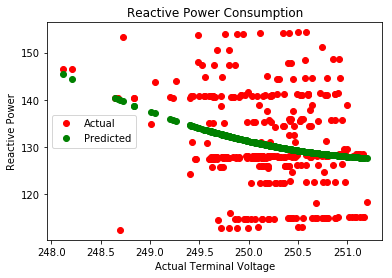

R SQUARED VALUES is 0.0630505662013
4 to 6


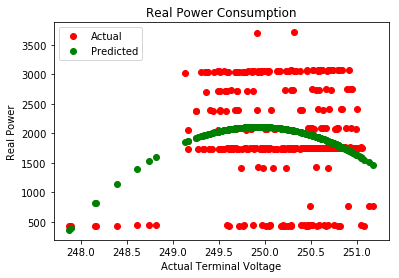

R SQUARED VALUES is 0.0641752592587


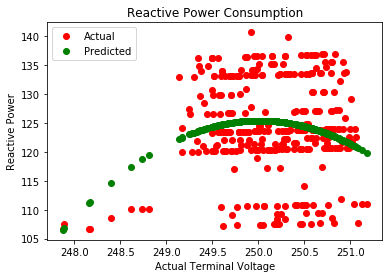

R SQUARED VALUES is 0.0670551040655
6 to 8


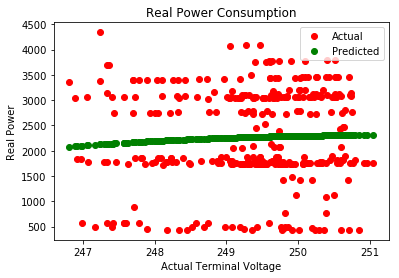

R SQUARED VALUES is 0.00287684867874


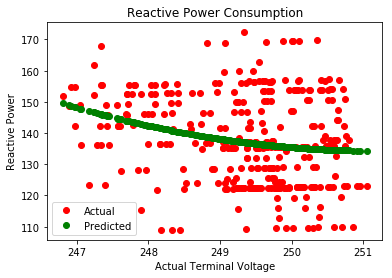

R SQUARED VALUES is 0.0570591260969
8 to 10


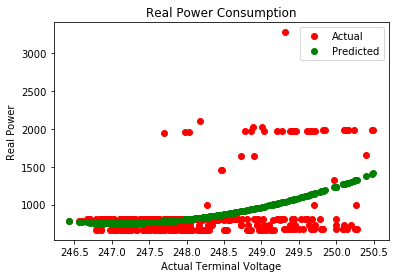

R SQUARED VALUES is 0.16419875537


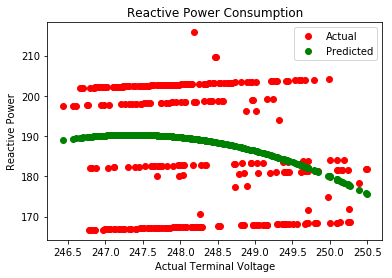

R SQUARED VALUES is 0.0494006258514
10 to 12


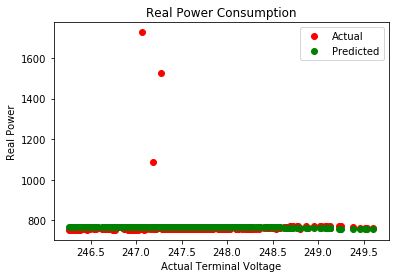

R SQUARED VALUES is 0.00116021854468


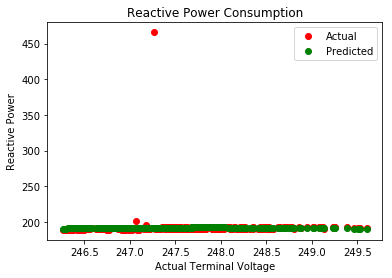

R SQUARED VALUES is 0.000735037992321
12 to 14


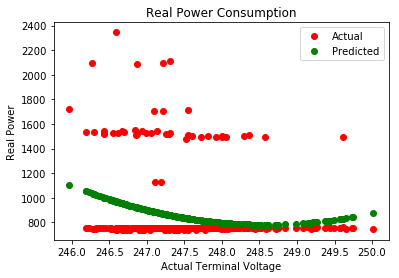

R SQUARED VALUES is 0.0528002642368


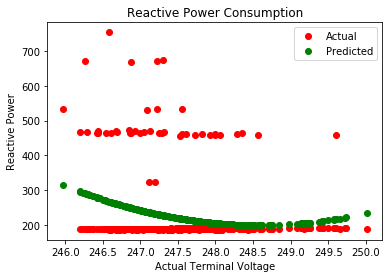

R SQUARED VALUES is 0.0523595149732
14 to 16


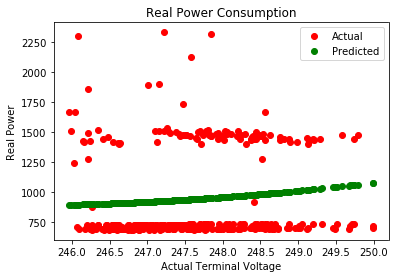

R SQUARED VALUES is 0.010643068929


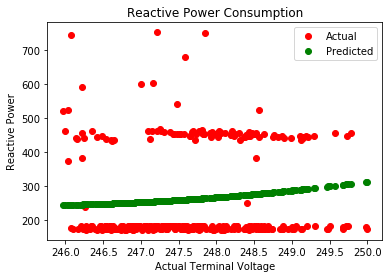

R SQUARED VALUES is 0.0113373883962
16 to 18


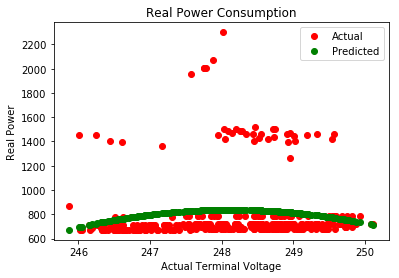

R SQUARED VALUES is 0.0154914280069


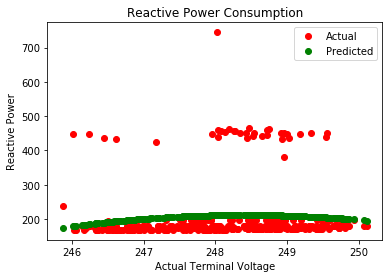

R SQUARED VALUES is 0.00789851941902
18 to 20


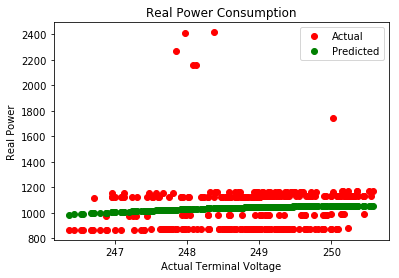

R SQUARED VALUES is 0.00560787866274


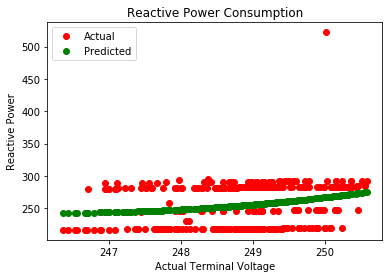

R SQUARED VALUES is 0.0523430898031
20 to 22


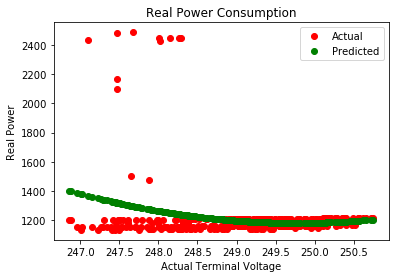

R SQUARED VALUES is 0.0529858468923


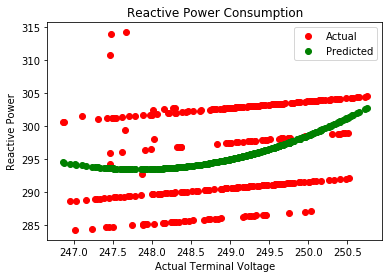

R SQUARED VALUES is 0.106072988009
22 to 24


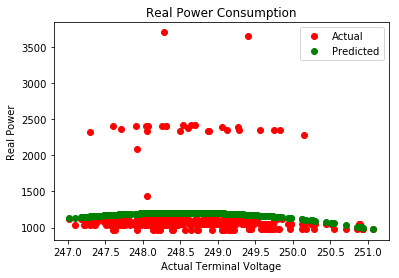

R SQUARED VALUES is 0.00876088742713


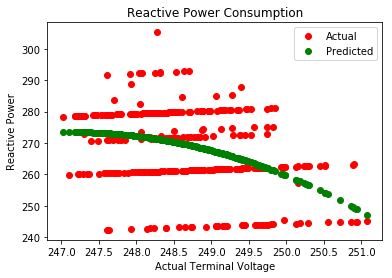

R SQUARED VALUES is 0.1567815594
Weekends
0 to 2


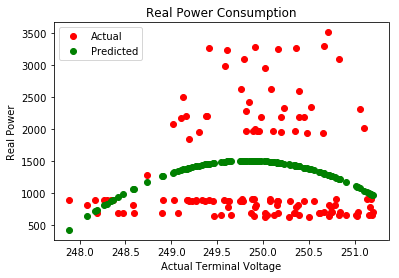

R SQUARED VALUES is 0.0690878898331


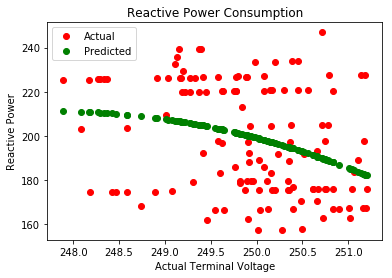

R SQUARED VALUES is 0.096994455497
2 to 4


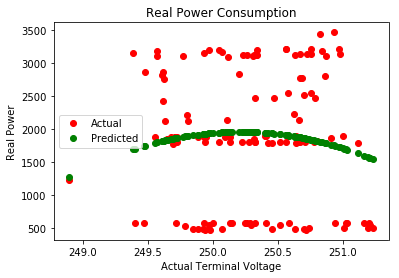

R SQUARED VALUES is 0.0117991331696


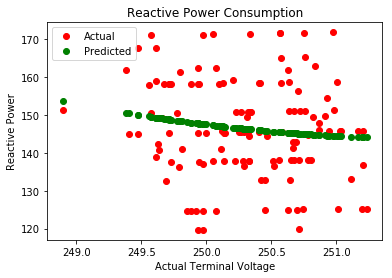

R SQUARED VALUES is 0.0189951922175
4 to 6


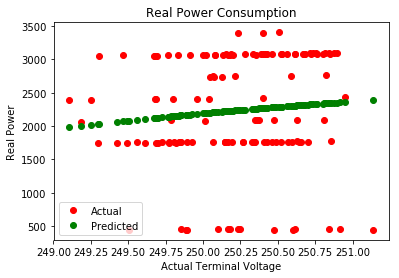

R SQUARED VALUES is 0.0100126795997


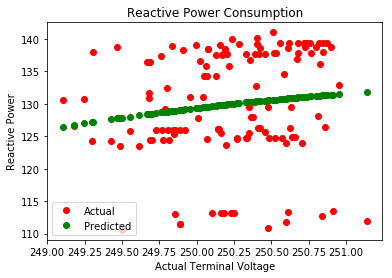

R SQUARED VALUES is 0.0175058628484
6 to 8


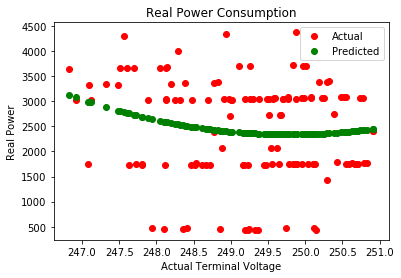

R SQUARED VALUES is 0.028981429459


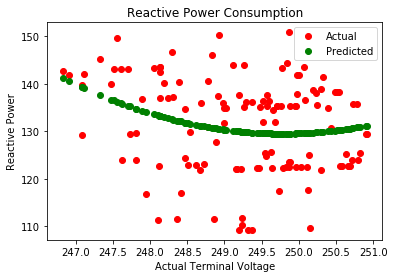

R SQUARED VALUES is 0.0651791434323
8 to 10


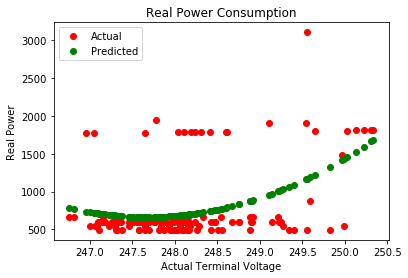

R SQUARED VALUES is 0.203901445143


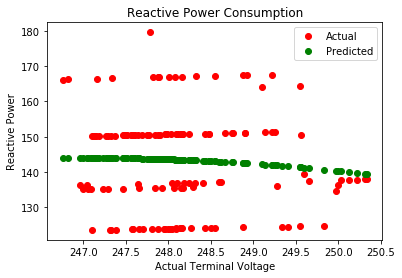

R SQUARED VALUES is 0.00595549094451
10 to 12


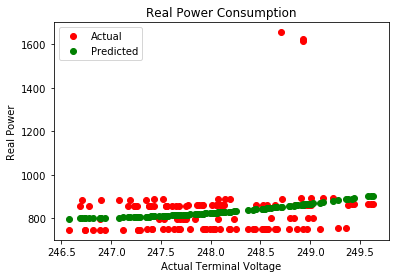

R SQUARED VALUES is 0.0388853200392


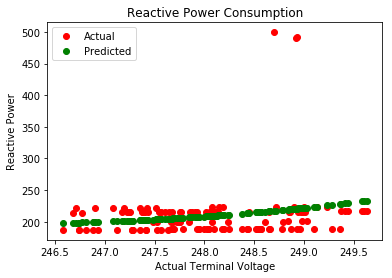

R SQUARED VALUES is 0.0361143196492
12 to 14


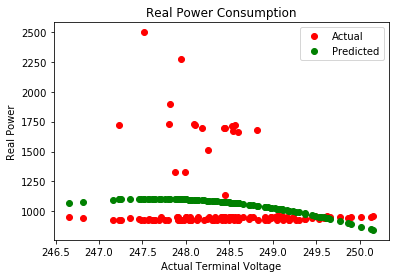

R SQUARED VALUES is 0.0411248627947


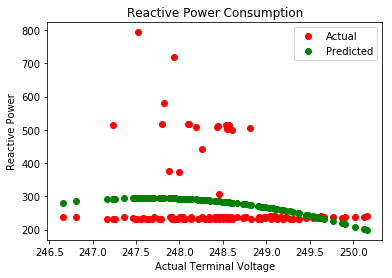

R SQUARED VALUES is 0.0430129013369
14 to 16


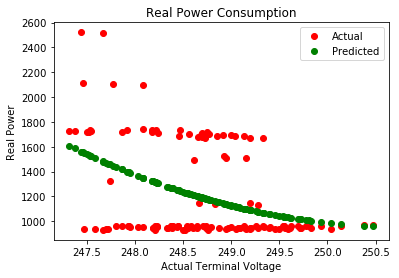

R SQUARED VALUES is 0.164078281527


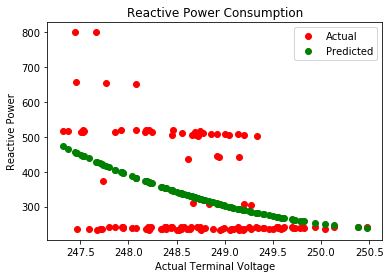

R SQUARED VALUES is 0.161081123744
16 to 18


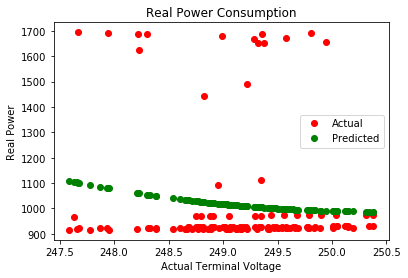

R SQUARED VALUES is 0.0150047219007


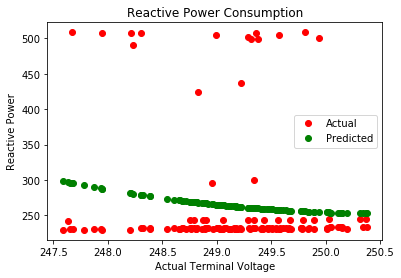

R SQUARED VALUES is 0.0155571424146
18 to 20


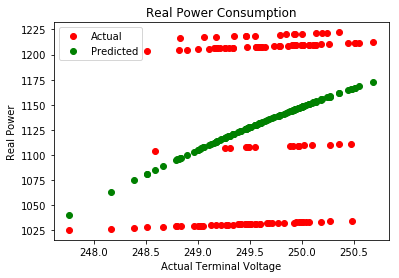

R SQUARED VALUES is 0.0755864160044


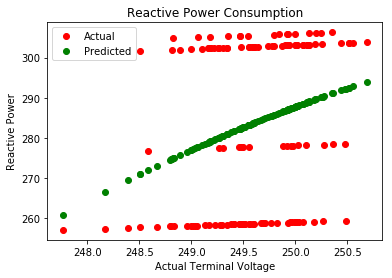

R SQUARED VALUES is 0.0755864187492
20 to 22


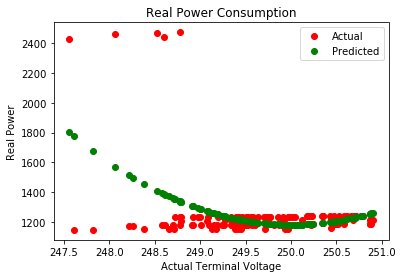

R SQUARED VALUES is 0.188364109422


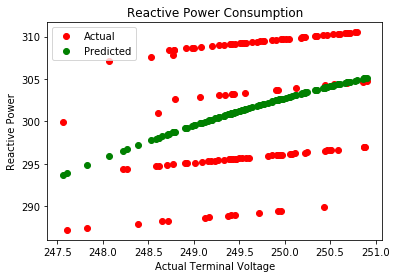

R SQUARED VALUES is 0.103782434838
22 to 24


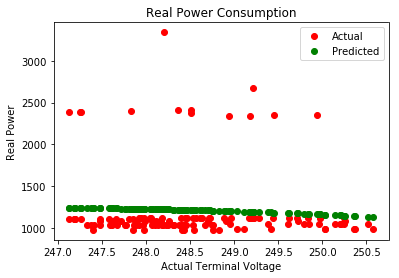

R SQUARED VALUES is 0.00401718526464


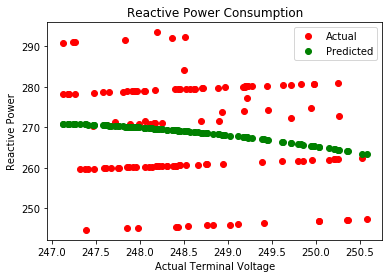

R SQUARED VALUES is 0.0240205530342
Season  2
2013-03-01
2013-05-15
Weekdays
0 to 2


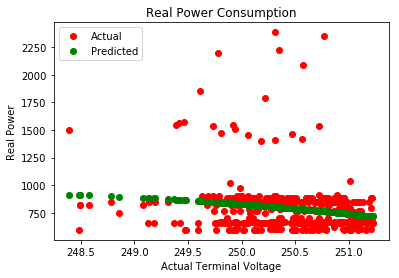

R SQUARED VALUES is 0.0293225549751


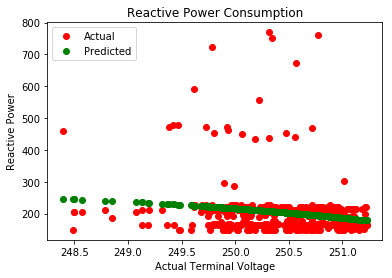

R SQUARED VALUES is 0.0276978690949
2 to 4


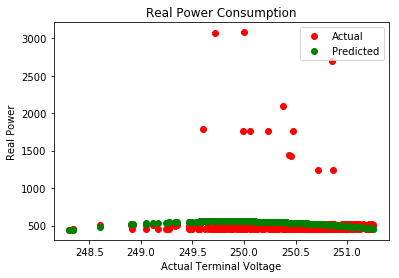

R SQUARED VALUES is 0.0106333563114


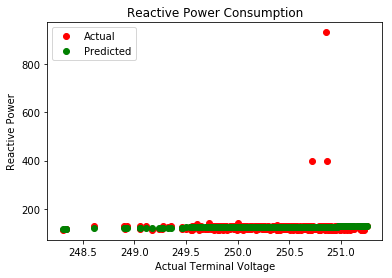

R SQUARED VALUES is 0.00121753199509
4 to 6


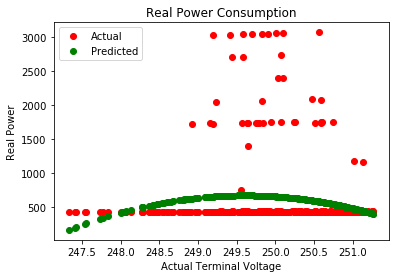

R SQUARED VALUES is 0.0279577321511


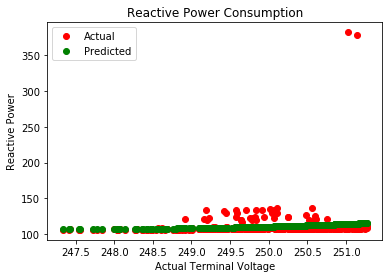

R SQUARED VALUES is 0.0126660215752
6 to 8


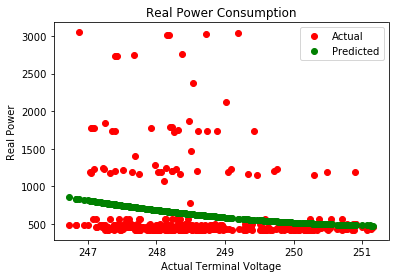

R SQUARED VALUES is 0.0387579302085


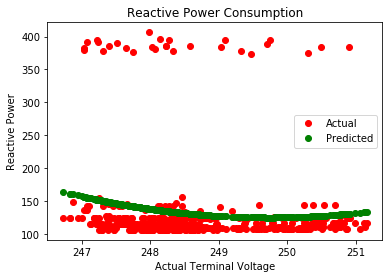

R SQUARED VALUES is 0.0171677554167
8 to 10


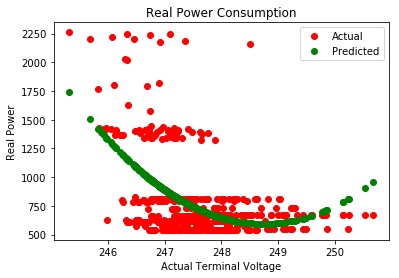

R SQUARED VALUES is 0.25250076751


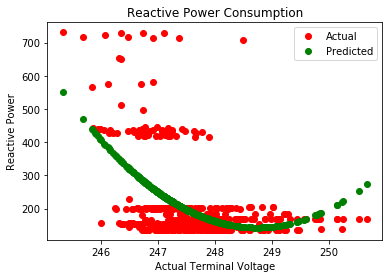

R SQUARED VALUES is 0.253708217415
10 to 12


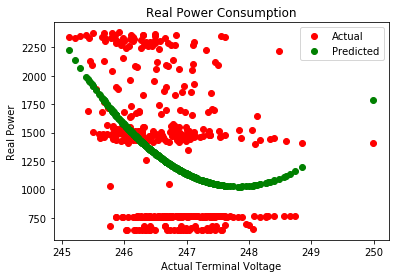

R SQUARED VALUES is 0.174808890778


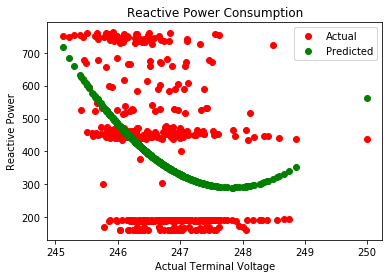

R SQUARED VALUES is 0.172726659288
12 to 14


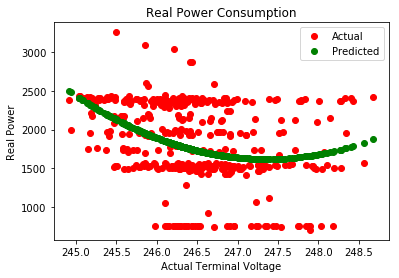

R SQUARED VALUES is 0.13655440207


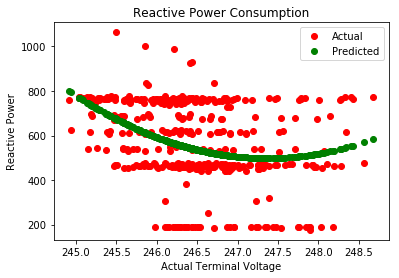

R SQUARED VALUES is 0.131320696797
14 to 16


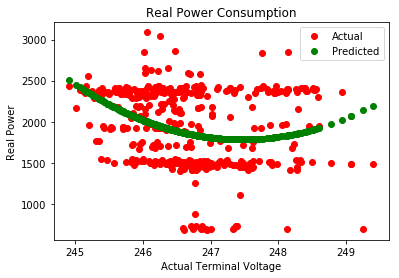

R SQUARED VALUES is 0.0907367046236


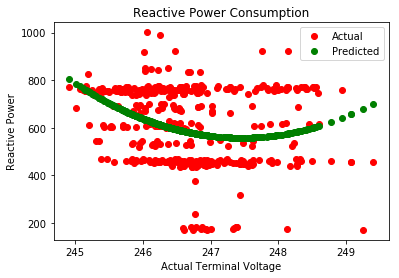

R SQUARED VALUES is 0.0878895063982
16 to 18


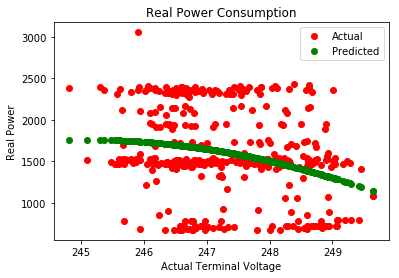

R SQUARED VALUES is 0.0727634818749


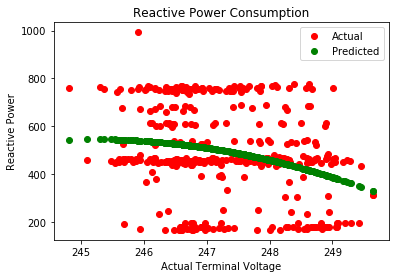

R SQUARED VALUES is 0.0725358725574
18 to 20


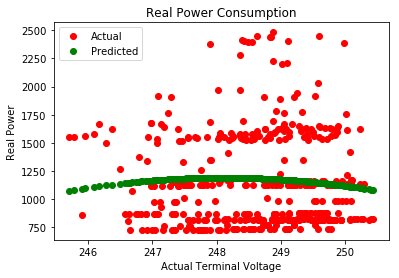

R SQUARED VALUES is 0.00358536673216


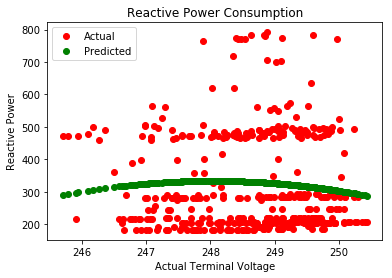

R SQUARED VALUES is 0.00489338619578
20 to 22


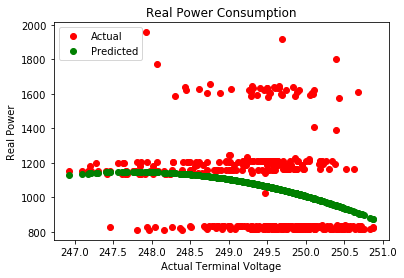

R SQUARED VALUES is 0.0610953727556


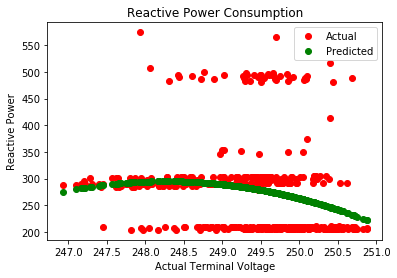

R SQUARED VALUES is 0.0364320617341
22 to 24


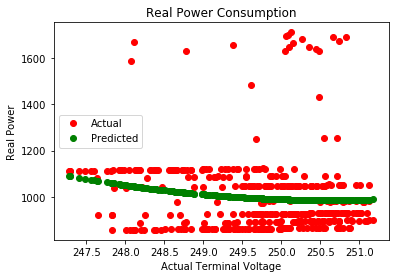

R SQUARED VALUES is 0.0168508581364


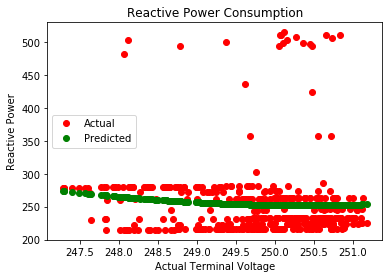

R SQUARED VALUES is 0.00596371077415
Weekends
0 to 2


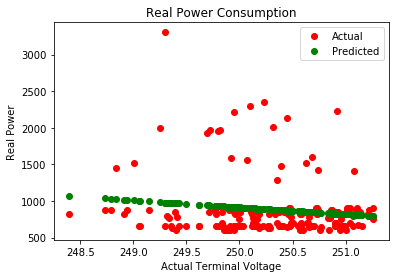

R SQUARED VALUES is 0.0180224794952


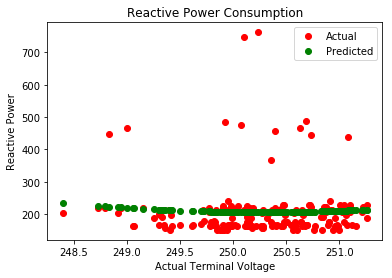

R SQUARED VALUES is 0.00208638770878
2 to 4


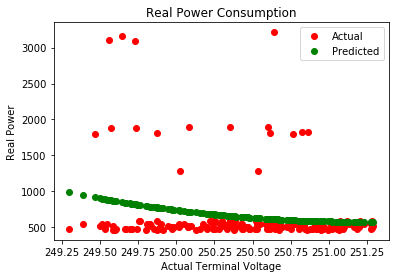

R SQUARED VALUES is 0.0386528223687


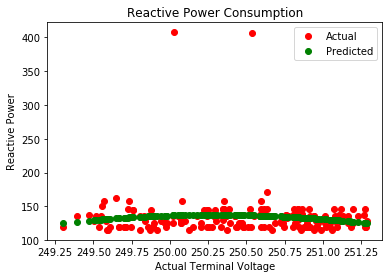

R SQUARED VALUES is 0.0106218499857
4 to 6


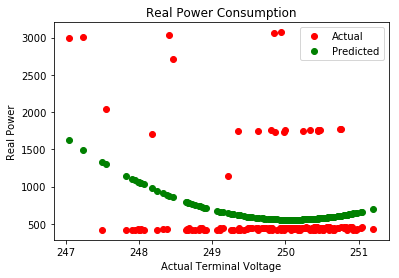

R SQUARED VALUES is 0.0883473642147


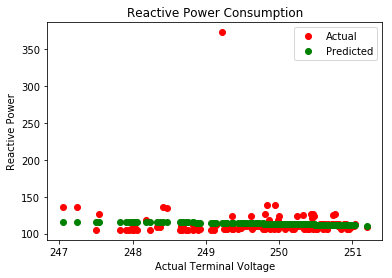

R SQUARED VALUES is 0.0040942770209
6 to 8


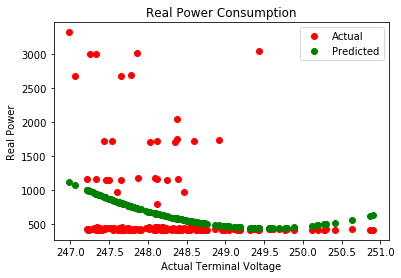

R SQUARED VALUES is 0.0758378404155


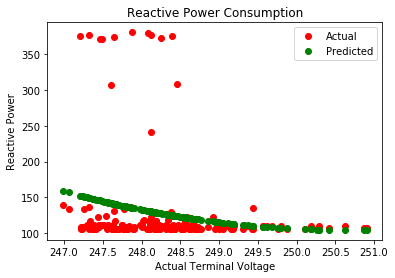

R SQUARED VALUES is 0.0412492994897
8 to 10


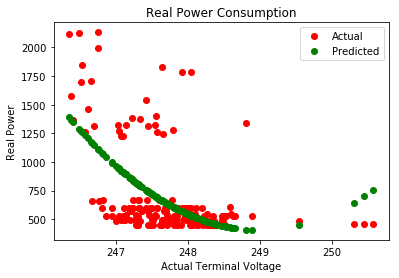

R SQUARED VALUES is 0.309117196003


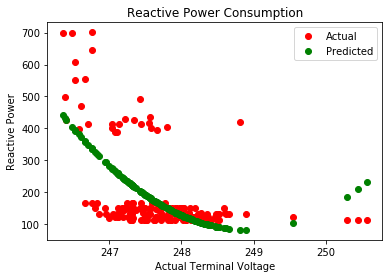

R SQUARED VALUES is 0.381936934459
10 to 12


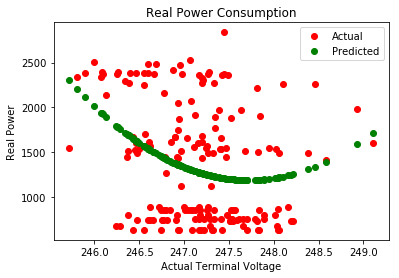

R SQUARED VALUES is 0.110473605266


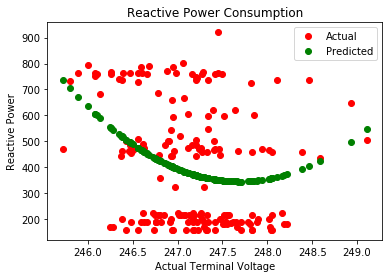

R SQUARED VALUES is 0.108254962544
12 to 14


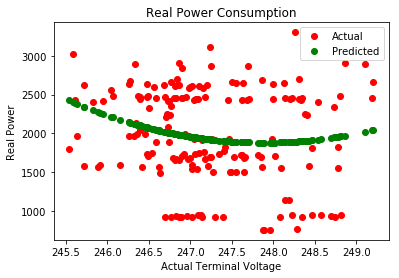

R SQUARED VALUES is 0.0349431271029


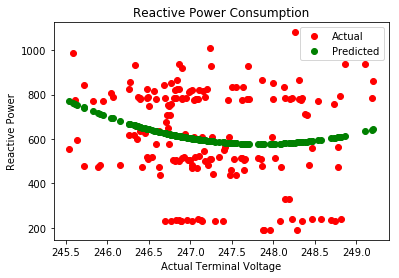

R SQUARED VALUES is 0.0348812497358
14 to 16


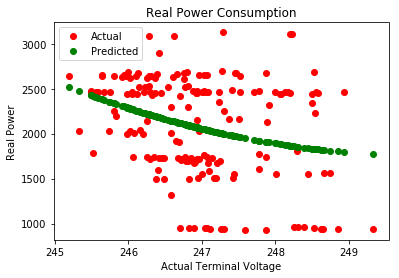

R SQUARED VALUES is 0.0846455766586


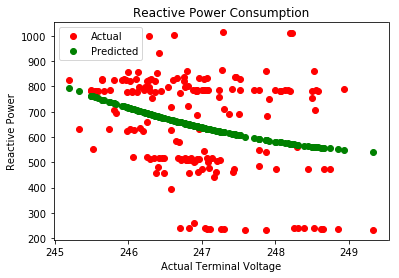

R SQUARED VALUES is 0.0788606766442
16 to 18


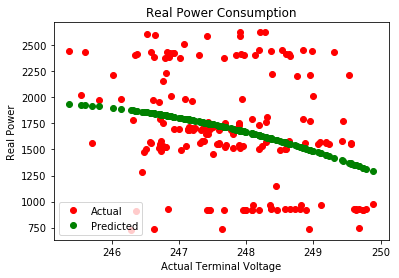

R SQUARED VALUES is 0.0857027676059


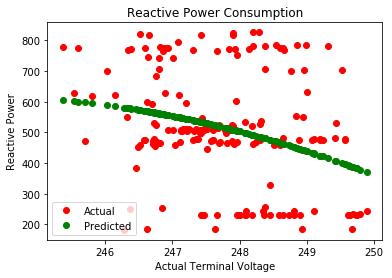

R SQUARED VALUES is 0.0884847517439
18 to 20


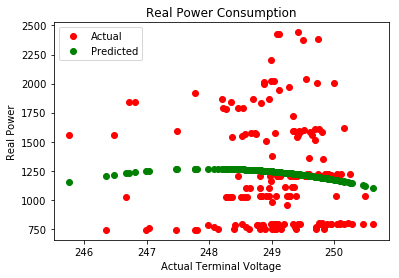

R SQUARED VALUES is 0.00622651184334


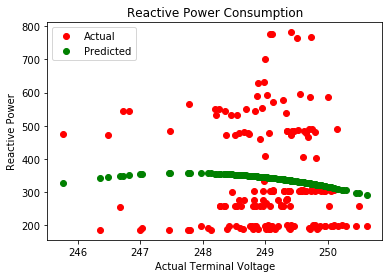

R SQUARED VALUES is 0.00841587898885
20 to 22


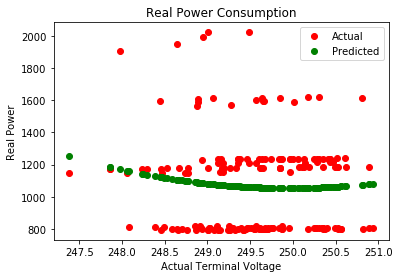

R SQUARED VALUES is 0.00968204506744


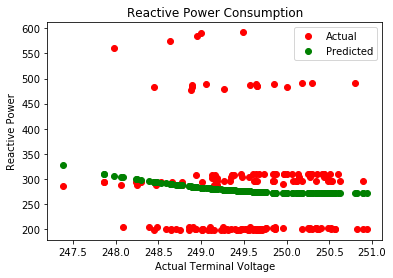

R SQUARED VALUES is 0.008931132587
22 to 24


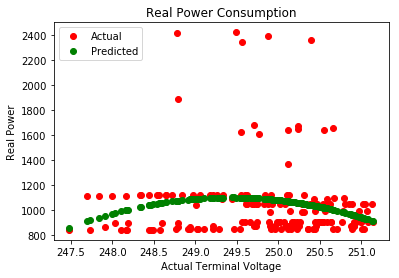

R SQUARED VALUES is 0.0326917730997


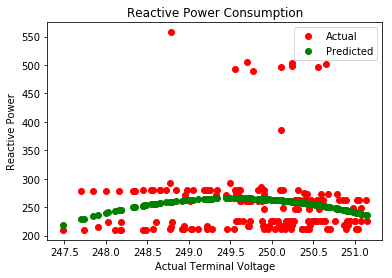

R SQUARED VALUES is 0.0207117962407
HOUR WINDOW IS 4
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 4


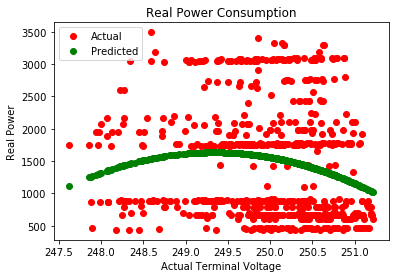

R SQUARED VALUES is 0.030758306057


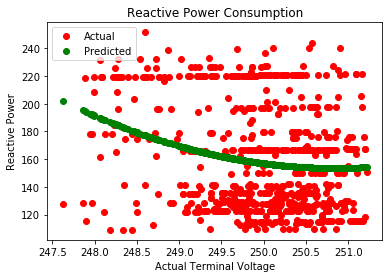

R SQUARED VALUES is 0.0486790683822
4 to 8


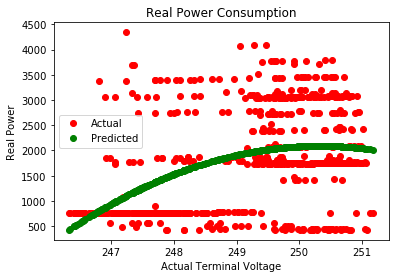

R SQUARED VALUES is 0.177830035529


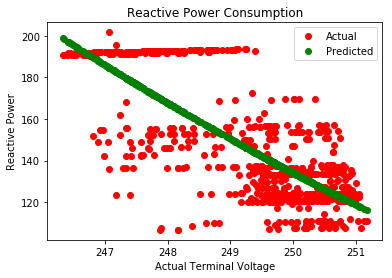

R SQUARED VALUES is 0.580302319588
8 to 12


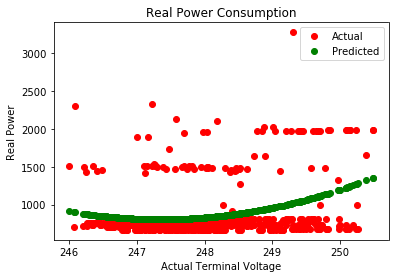

R SQUARED VALUES is 0.0901780490161


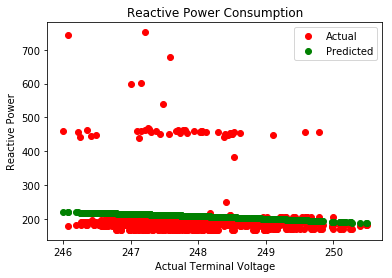

R SQUARED VALUES is 0.0074384369319
12 to 16


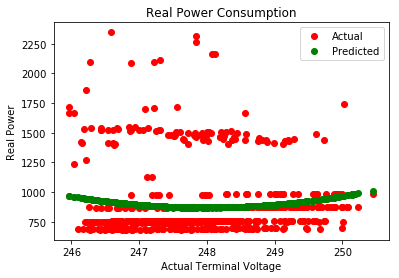

R SQUARED VALUES is 0.00742841202533


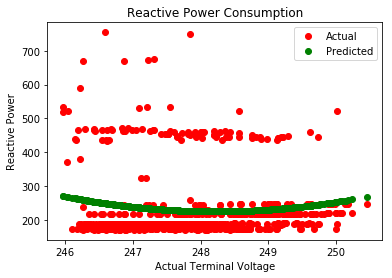

R SQUARED VALUES is 0.00967897221659
16 to 20


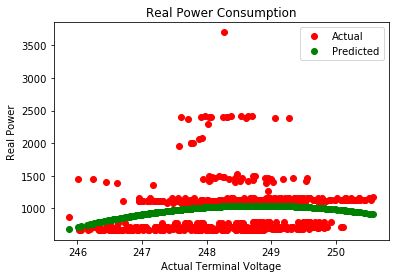

R SQUARED VALUES is 0.0335516020015


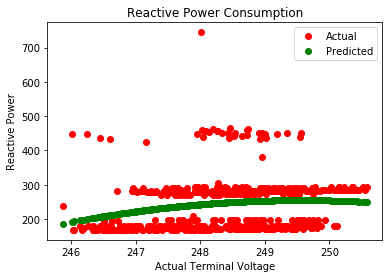

R SQUARED VALUES is 0.0372084610473
20 to 24


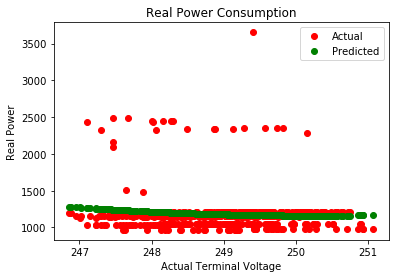

R SQUARED VALUES is 0.00925240949157


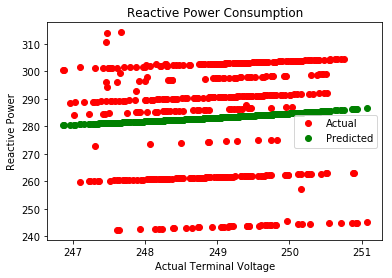

R SQUARED VALUES is 0.00427187604251
Weekends
0 to 4


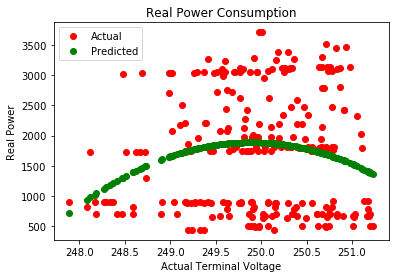

R SQUARED VALUES is 0.0414654351448


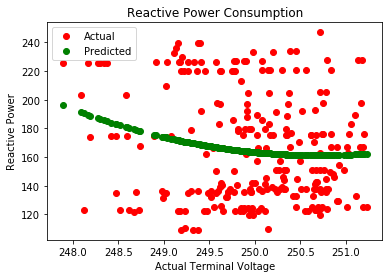

R SQUARED VALUES is 0.0297049605482
4 to 8


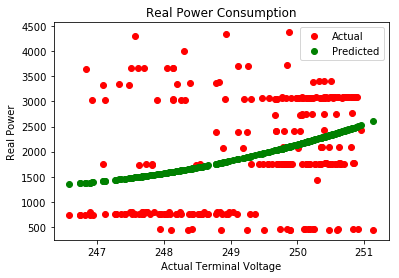

R SQUARED VALUES is 0.1008072188


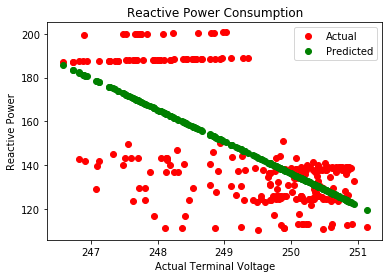

R SQUARED VALUES is 0.407140993991
8 to 12


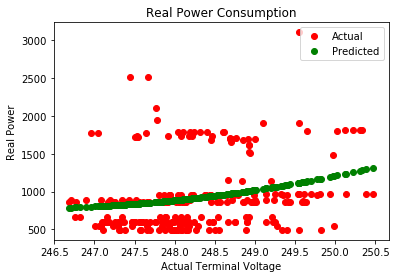

R SQUARED VALUES is 0.0603123324593


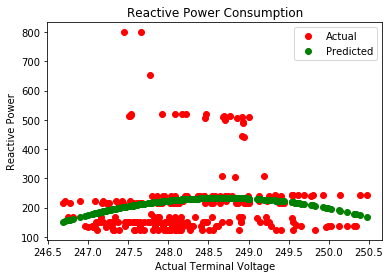

R SQUARED VALUES is 0.0238707325625
12 to 16


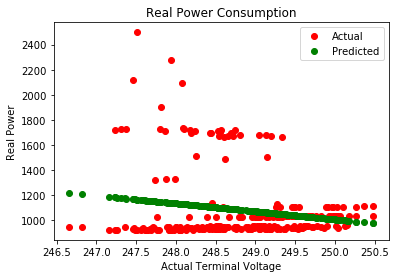

R SQUARED VALUES is 0.0311354172537


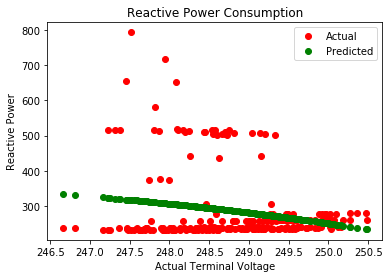

R SQUARED VALUES is 0.0423428728456
16 to 20


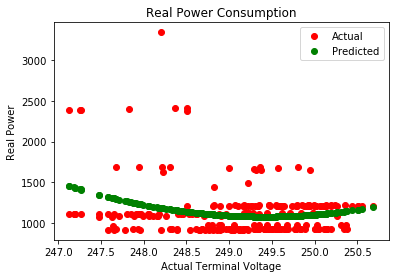

R SQUARED VALUES is 0.0654310679868


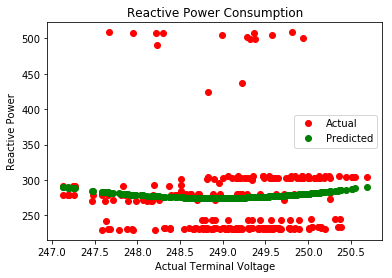

R SQUARED VALUES is 0.00373048172602
20 to 24


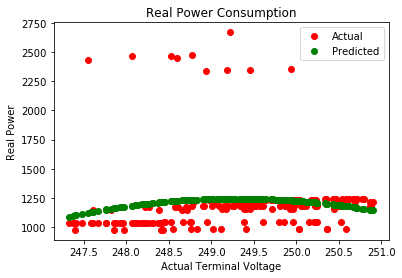

R SQUARED VALUES is 0.0141133765334


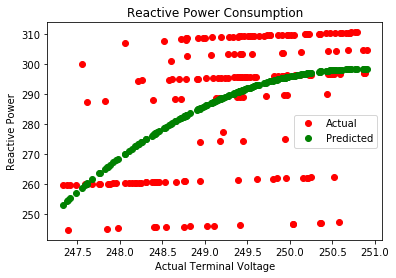

R SQUARED VALUES is 0.270466238685
Season  2
2013-03-01
2013-05-15
Weekdays
0 to 4


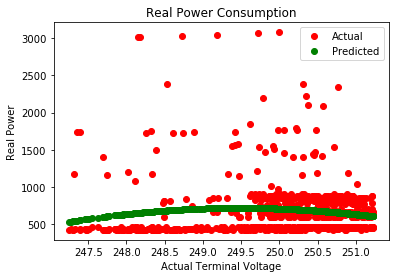

R SQUARED VALUES is 0.0103792237242


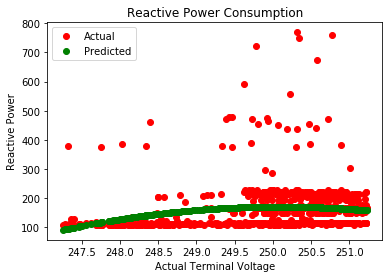

R SQUARED VALUES is 0.0327946650691
4 to 8


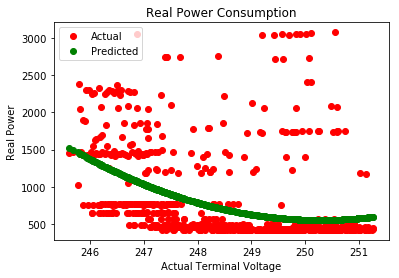

R SQUARED VALUES is 0.180716978024


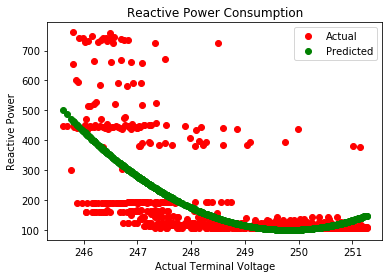

R SQUARED VALUES is 0.436003105734
8 to 12


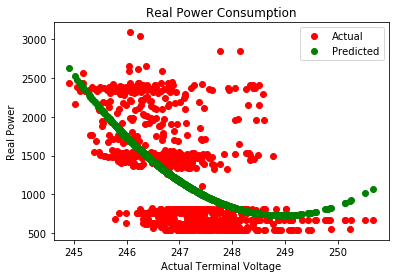

R SQUARED VALUES is 0.342236211928


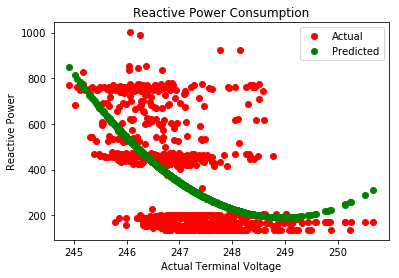

R SQUARED VALUES is 0.338785665847
12 to 16


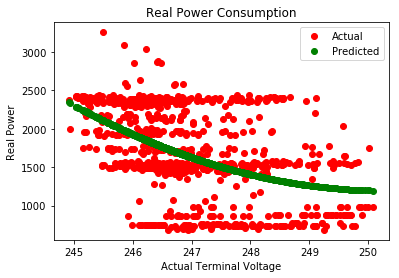

R SQUARED VALUES is 0.22187167099


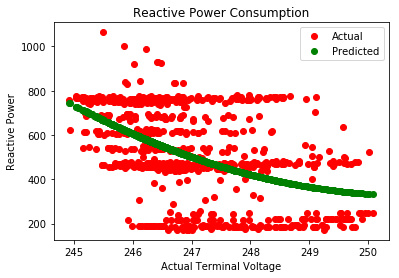

R SQUARED VALUES is 0.224442624569
16 to 20


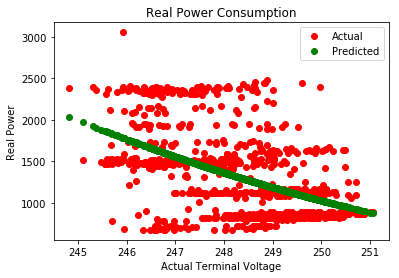

R SQUARED VALUES is 0.229334577549


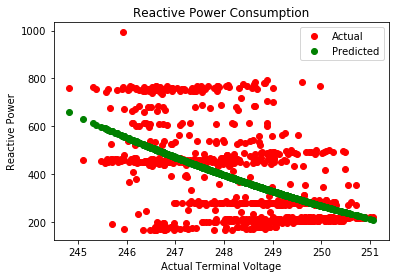

R SQUARED VALUES is 0.253732880487
20 to 24


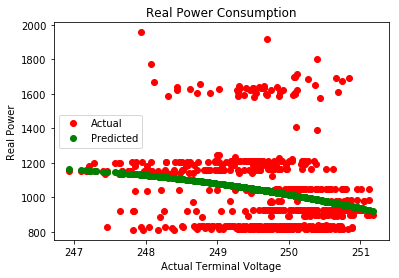

R SQUARED VALUES is 0.0504334637492


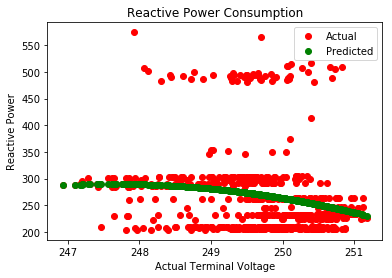

R SQUARED VALUES is 0.0330028117105
Weekends
0 to 4


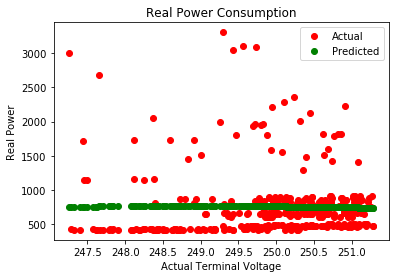

R SQUARED VALUES is 0.000201749856999


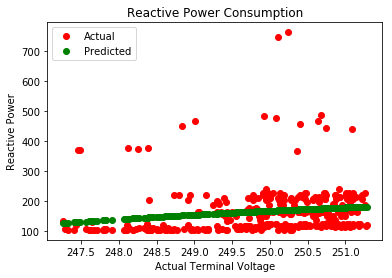

R SQUARED VALUES is 0.0239025250733
4 to 8


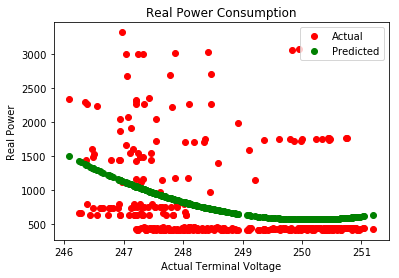

R SQUARED VALUES is 0.126661178339


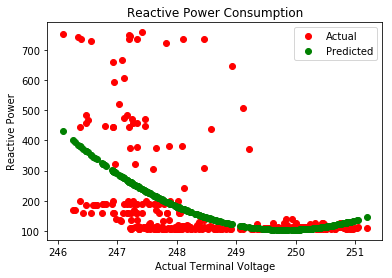

R SQUARED VALUES is 0.258952215869
8 to 12


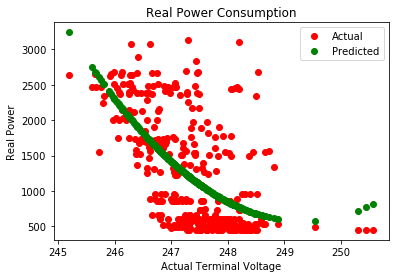

R SQUARED VALUES is 0.367013289079


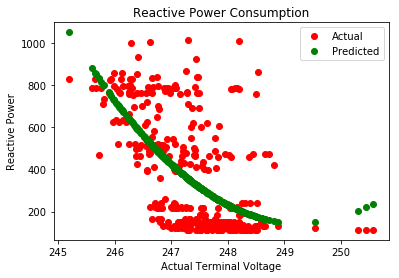

R SQUARED VALUES is 0.368333343135
12 to 16


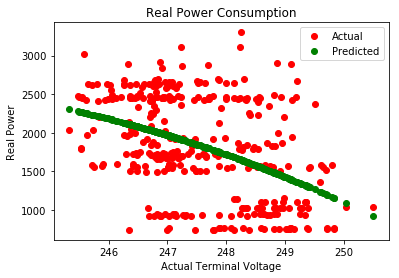

R SQUARED VALUES is 0.184465608977


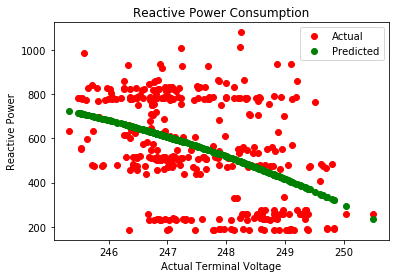

R SQUARED VALUES is 0.183865660663
16 to 20


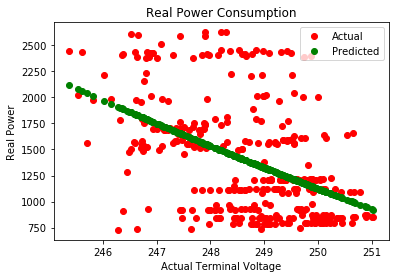

R SQUARED VALUES is 0.225125879399


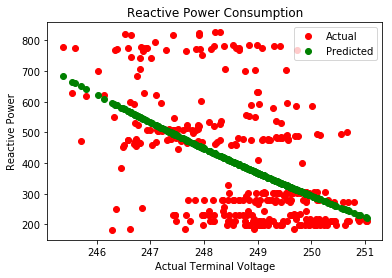

R SQUARED VALUES is 0.264006691134
20 to 24


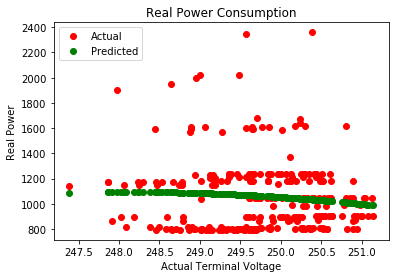

R SQUARED VALUES is 0.00861291332412


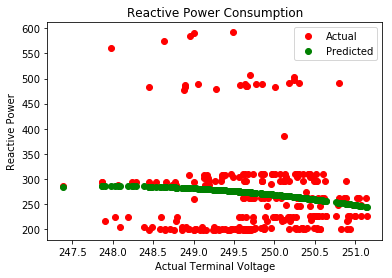

R SQUARED VALUES is 0.0144217520573
HOUR WINDOW IS 8
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 8


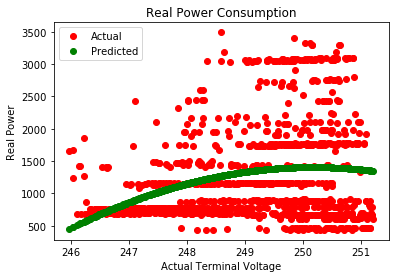

R SQUARED VALUES is 0.0825006802725


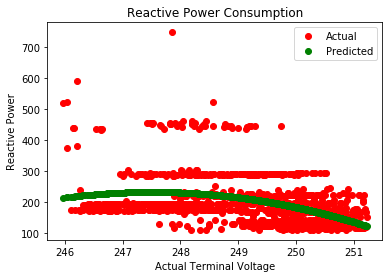

R SQUARED VALUES is 0.148453431114
8 to 16


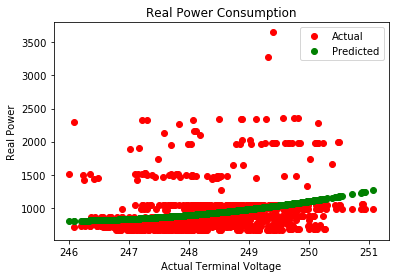

R SQUARED VALUES is 0.0700618728789


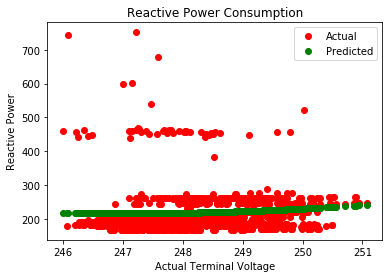

R SQUARED VALUES is 0.00499915187739
16 to 24


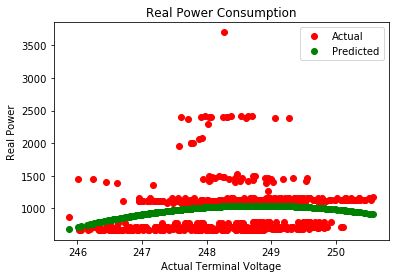

R SQUARED VALUES is 0.0335516020015


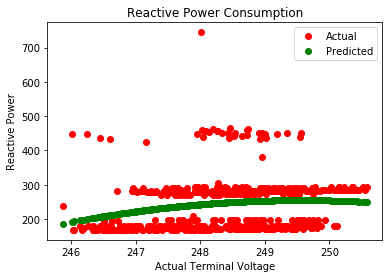

R SQUARED VALUES is 0.0372084610473
Weekends
0 to 8


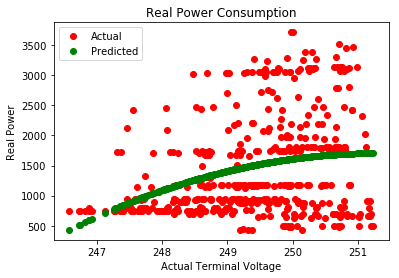

R SQUARED VALUES is 0.0934997419893


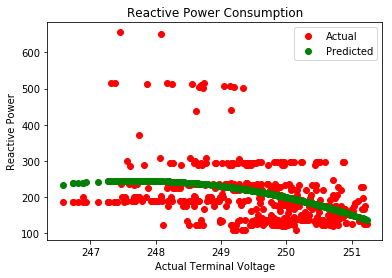

R SQUARED VALUES is 0.113592481008
8 to 16


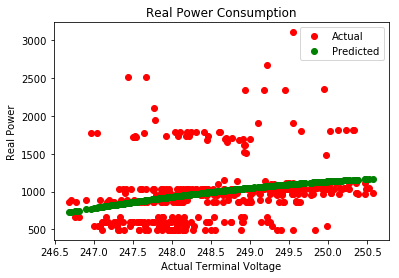

R SQUARED VALUES is 0.0647879885237


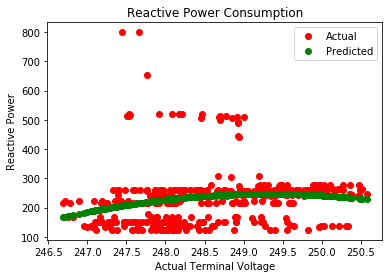

R SQUARED VALUES is 0.0314955228538
16 to 24


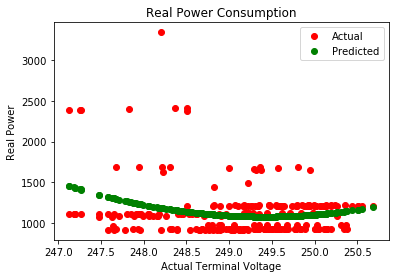

R SQUARED VALUES is 0.0654310679868


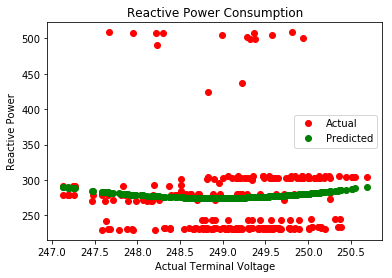

R SQUARED VALUES is 0.00373048172602
Season  2
2013-03-01
2013-05-15
Weekdays
0 to 8


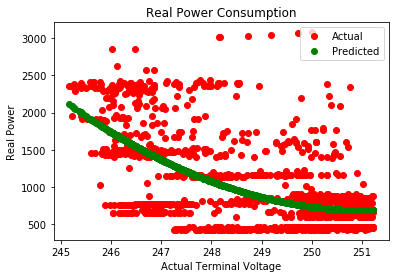

R SQUARED VALUES is 0.365640565313


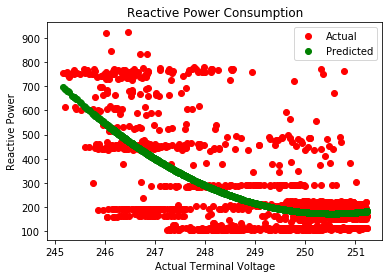

R SQUARED VALUES is 0.420677151678
8 to 16


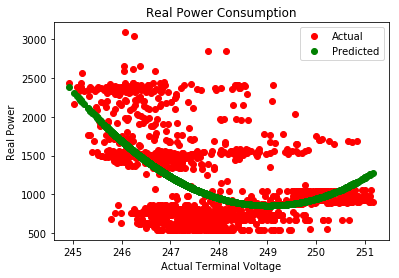

R SQUARED VALUES is 0.275697166469


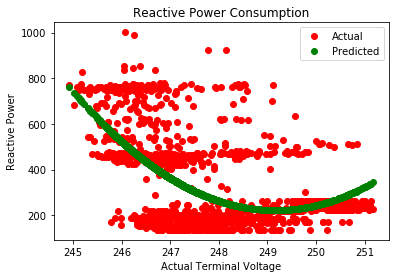

R SQUARED VALUES is 0.289948438019
16 to 24


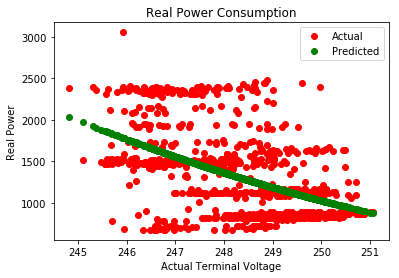

R SQUARED VALUES is 0.229334577549


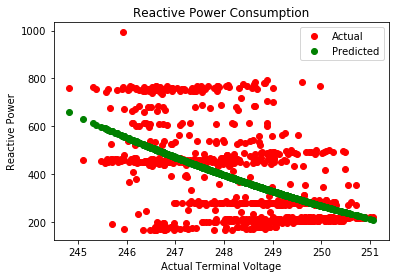

R SQUARED VALUES is 0.253732880487
Weekends
0 to 8


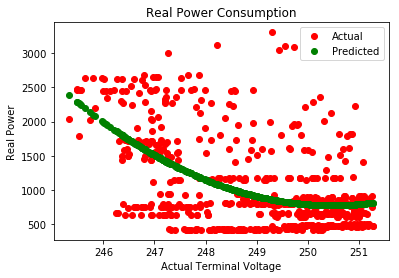

R SQUARED VALUES is 0.277778885277


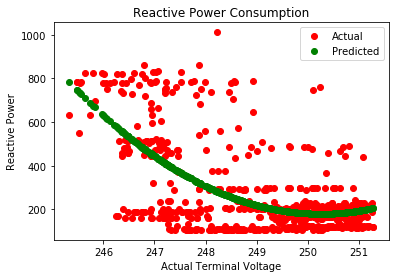

R SQUARED VALUES is 0.381055052392
8 to 16


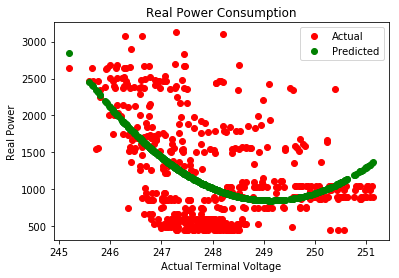

R SQUARED VALUES is 0.26252435443


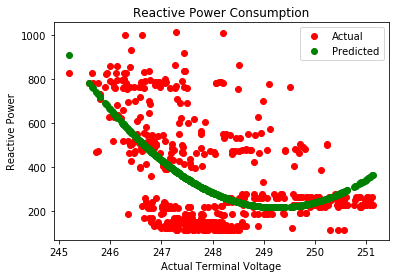

R SQUARED VALUES is 0.288573992929
16 to 24


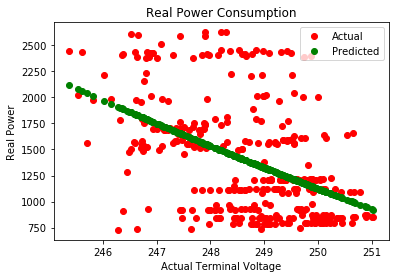

R SQUARED VALUES is 0.225125879399


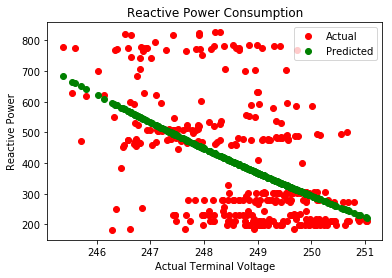

R SQUARED VALUES is 0.264006691134
HOUR WINDOW IS 12
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 12


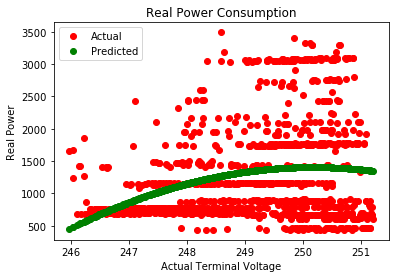

R SQUARED VALUES is 0.0825006802725


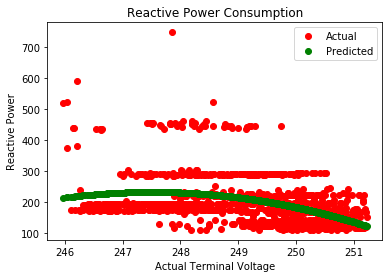

R SQUARED VALUES is 0.148453431114
12 to 24


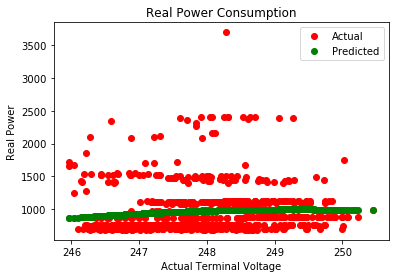

R SQUARED VALUES is 0.00787712669683


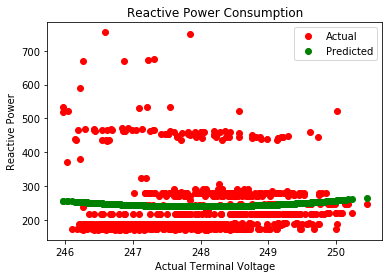

R SQUARED VALUES is 0.00226312675825
Weekends
0 to 12


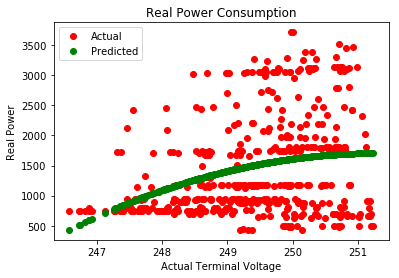

R SQUARED VALUES is 0.0934997419893


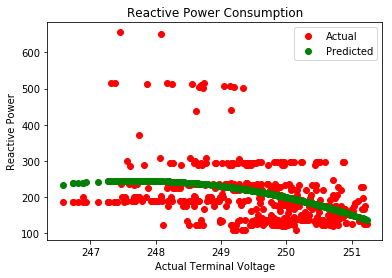

R SQUARED VALUES is 0.113592481008
12 to 24


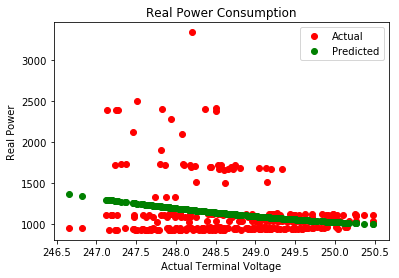

R SQUARED VALUES is 0.0490629549502


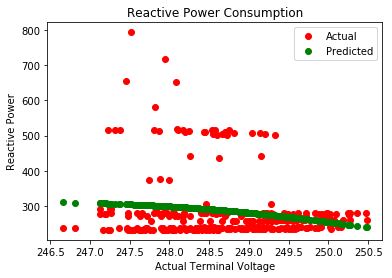

R SQUARED VALUES is 0.0312160283537
Season  2
2013-03-01
2013-05-15
Weekdays
0 to 12


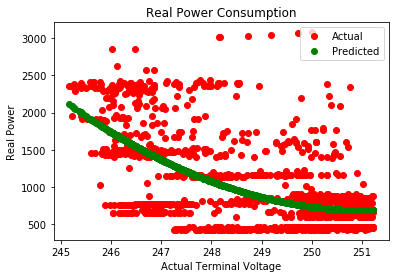

R SQUARED VALUES is 0.365640565313


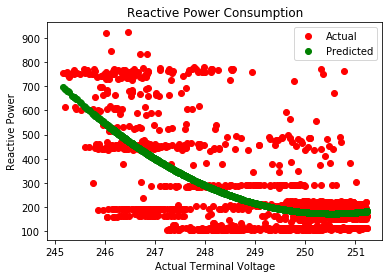

R SQUARED VALUES is 0.420677151678
12 to 24


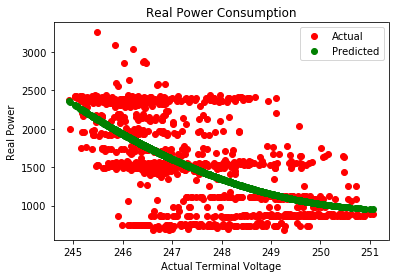

R SQUARED VALUES is 0.360186721893


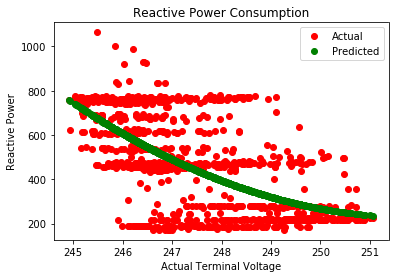

R SQUARED VALUES is 0.376347996048
Weekends
0 to 12


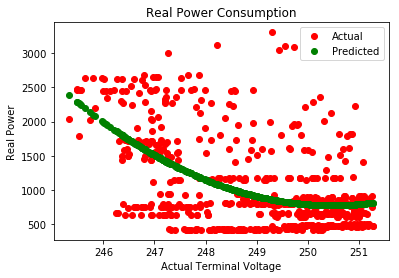

R SQUARED VALUES is 0.277778885277


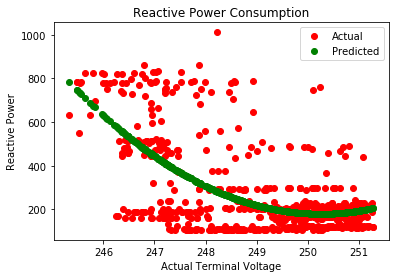

R SQUARED VALUES is 0.381055052392
12 to 24


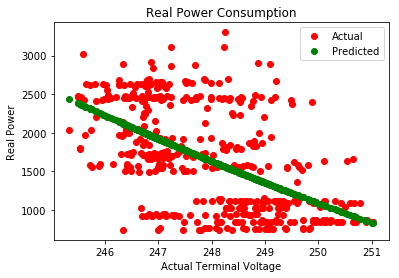

R SQUARED VALUES is 0.295214462209


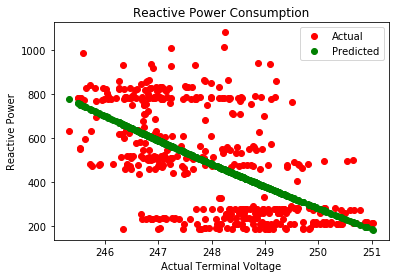

R SQUARED VALUES is 0.316863870335
HOUR WINDOW IS 24
Season  1
2013-01-01
2013-03-01
Weekdays
0 to 24


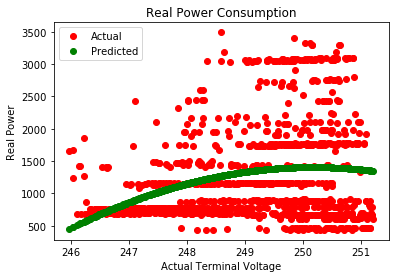

R SQUARED VALUES is 0.0825006802725


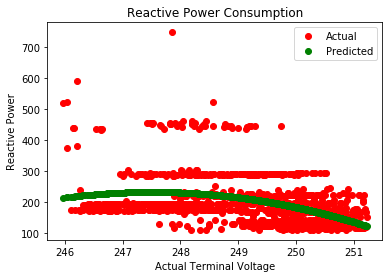

R SQUARED VALUES is 0.148453431114
Weekends
0 to 24


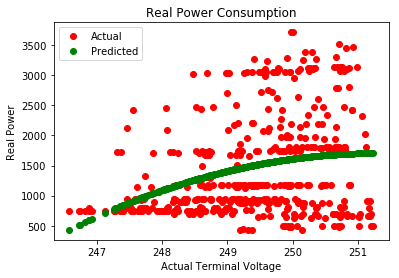

R SQUARED VALUES is 0.0934997419893


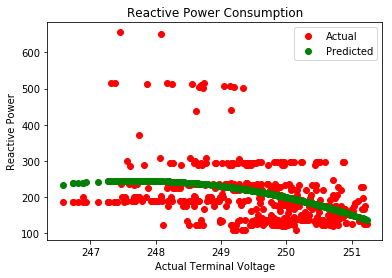

R SQUARED VALUES is 0.113592481008
Season  2
2013-03-01
2013-05-15
Weekdays
0 to 24


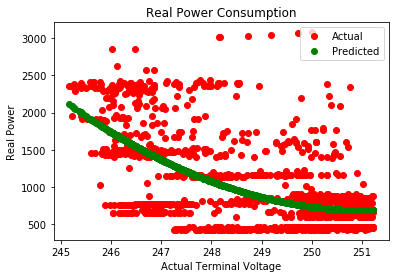

R SQUARED VALUES is 0.365640565313


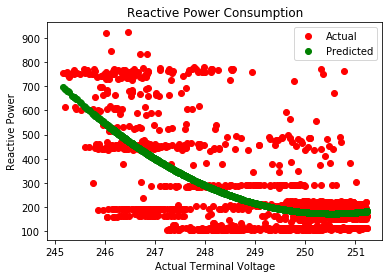

R SQUARED VALUES is 0.420677151678
Weekends
0 to 24


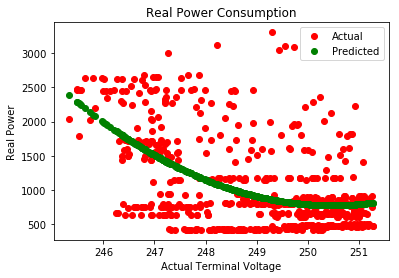

R SQUARED VALUES is 0.277778885277


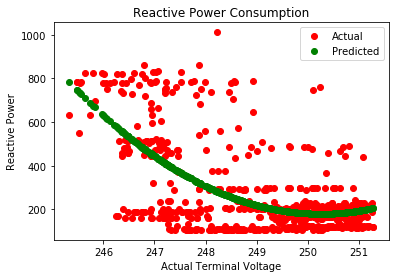

R SQUARED VALUES is 0.381055052392


In [23]:
# TODO- make this a function and call it over each meter

hourWindowDict=collections.OrderedDict()
for hourWindow in hourWindows:
    hourWindowKey="HourWindowOf"+str(hourWindow)
    print("HOUR WINDOW IS",hourWindow)
    
    seasonDict=collections.OrderedDict()
    for j in range(0,len(seasonDates)-1):
        
        # Extract only those instance from the dataframe that are within the range of seasonDates
        realPowerSeason=realP[seasonDates[j]:seasonDates[j+1]]
        realVoltageSeason=realV[seasonDates[j]:seasonDates[j+1]]
        reactivePowerSeason=reactiveP[seasonDates[j]:seasonDates[j+1]]
        reactiveVoltageSeason=reactiveV[seasonDates[j]:seasonDates[j+1]]
        temperatureSeason=amiTemp[seasonDates[j]:seasonDates[j+1]]
    
        # get the dates within the range of dates. This will be used to check which dates within the range are weekdays and weekends
        date_list=getDateList(seasonDates[j],seasonDates[j+1])
        
        print("Season ",j+1)
        print(seasonDates[j])
        print(seasonDates[j+1])
        seasonKey="Season"+str(j+1)
    
        dayTypeDict=collections.OrderedDict()
        
        for i in ('weekdays','weekends'):
            if i=='weekdays':
                dayTypeKey="weekdays"
                
                # extract only those days from the dateList which are weekdays
                days=[(day.strftime('%Y-%m-%d')) for day in date_list if (day.isoweekday()==1 or day.isoweekday()==2 or day.isoweekday()==3 or day.isoweekday()==4 or day.isoweekday()==5)]
                print("Weekdays")
            
            else:
                dayTypeKey="weekends"
                
                # extract only those days from the dateList which are weekends
                days=[(day.strftime('%Y-%m-%d')) for day in date_list if (day.isoweekday()==6 or day.isoweekday()==7)]
                print("Weekends")
        
            
            # get only those instances which weekdays or weekends depending on what value 'days' holds
            totalrealPower=getDays(realPowerSeason,days)
            totalrealVoltage=getDays(realVoltageSeason,days)
            totalreactivePower=getDays(reactivePowerSeason,days)
            totalreactiveVoltage=getDays(reactiveVoltageSeason,days)
            totaltemperature=getDays(temperatureSeason,days)
            
            hourDict=collections.OrderedDict()
            hr=0
            while hr <24:
                
                # getHourData takes the extracted DataFrame from previous step, hourWindow and the value of hr at that instant
                realPower=getHourData(totalrealPower,hourWindow,hr)
                realVoltage=getHourData(totalrealVoltage,hourWindow,hr)
                reactivePower=getHourData(totalreactivePower,hourWindow,hr)
                reactiveVoltage=getHourData(totalreactiveVoltage,hourWindow,hr)
                temperature=getHourData(totaltemperature,hourWindow,hr)

                hourKey=str(hr)+" to "+str(hr+hourWindow)
                print(hourKey)
                
                hr=hr+hourWindow
                
                apparentVoltage=((realVoltage**2)+(reactiveVoltage**2))**0.5
                apparentPower=((realPower**2)+(reactivePower**2))**0.5
                independentVariable=apparentVoltage/apparentVoltage.mean() # or .median()
                
                nominalPower= getNominalPower(apparentPower, apparentVoltage) #Sn value
    
                columnNames=independentVariable.columns
                
                t=temperature.values
                t=np.reshape(t,len(t))
                
                x=independentVariable[columnNames[0]]
                x=x.values
            
                xaxis=apparentVoltage[columnNames[0]] # used for defining the axis in the graph
                
                y1=realPower[columnNames[0]].values
                y2=reactivePower[columnNames[0]].values
            
                                
                #c1, covar = curve_fit(realFunc, (x,t,nominalPower), y1,maxfev=50000)#,method='lm',p0=init_vals)
                #print("NEW FUNCTION1",c1)
                #c2, covar = curve_fit(reactiveFunc, (x,t,nominalPower), y2,maxfev=800000)#,method='lm',p0=init_vals)
                #print("NEW FUNCTION 2",c2)
                
                # REAL COEFFICIENTS
                coefficient1, covar = curve_fit(myfunc, (x,t), y1,maxfev=8000)#,method='lm',p0=init_vals)
                rms1=RMS(y1,myfunc((x,t),coefficient1[0],coefficient1[1],coefficient1[2]))
                rSqr1=rSquared(x,y1,myfunc((x,t),coefficient1[0],coefficient1[1],coefficient1[2]))
                
                fid,cx = pyplot.subplots()
                cx.plot(xaxis,y1,'ro',label='Actual')
                cx.plot(xaxis,myfunc((x,t),coefficient1[0],coefficient1[1],coefficient1[2]),'go',label='Predicted')          
                cx.legend()
                cx.set_title('Real Power Consumption')
                cx.set_xlabel('Actual Terminal Voltage')
                cx.set_ylabel('Real Power')
                pyplot.show()
                print("R SQUARED VALUES is", rSqr1)

                
                # REACTIVE COEFFICIENTS
                coefficient2, covar = curve_fit(myfunc, (x,t), y2,maxfev=8000)#,method='lm',p0=init_vals)
                rms2=RMS(y2,myfunc((x,t),coefficient2[0],coefficient2[1],coefficient2[2]))
                rSqr2=rSquared(x,y2,myfunc((x,t),coefficient2[0],coefficient2[1],coefficient2[2]))
                
                fid,cx = pyplot.subplots()
                cx.plot(xaxis,y2,'ro',label='Actual')
                cx.plot(xaxis,myfunc((x,t),coefficient2[0],coefficient2[1],coefficient2[2]),'go',label='Predicted')
                cx.legend()
                cx.set_title('Reactive Power Consumption')
                cx.set_xlabel('Actual Terminal Voltage')
                cx.set_ylabel('Reactive Power')
                pyplot.show()
                print("R SQUARED VALUES is", rSqr2)
                
                finalCoefficients1,finalCoefficients2=processCoefficients(coefficient1,coefficient2,nominalPower)
                
                # Real hour
                hourValuesReal=np.append(coefficient1,rms1)
                #print('hourValuesReal1',hourValuesReal)
                hourValuesReal=np.append(hourValuesReal, rSqr1)
                #print('hourValuesReal2',hourValuesReal)
                hourValuesReal=np.append(hourValuesReal, finalCoefficients1)
                hourValuesReal=np.append(hourValuesReal, sum(finalCoefficients1))
                #print('hourValuesReal3',hourValuesReal)
                
                hourValuesReactive=np.append(coefficient2,rms2)
                hourValuesReactive=np.append(hourValuesReactive, rSqr2)
                hourValuesReactive=np.append(hourValuesReactive, finalCoefficients2)
                hourValuesReactive=np.append(hourValuesReactive, sum(finalCoefficients2))
                
                innerDict={'real': pd.DataFrame(np.reshape(hourValuesReal,(1,len(hourValuesReal)))), 'reactive':pd.DataFrame(np.reshape(hourValuesReactive,(1,len(hourValuesReactive))))}
                #print("InnerDict", innerDict)
                df=pd.concat(innerDict)
                df=df.reset_index(level=1, drop=True) # while creating the dataFrame it adds its own numerical index. So this would drop that numerical index
                
                # creating a dictionary with hourKey which holds the DataFrame from the previous step as the value. Later this dictionary will be moved to a DataFrame
                hourDict[hourKey]=df
                
            outerDF=pd.concat(hourDict)
            dayTypeDict[dayTypeKey]=outerDF
            
        oouterDF=pd.concat(dayTypeDict)
        seasonDict[seasonKey]=oouterDF
        
    seasonDF=pd.concat(seasonDict)
    hourWindowDict[hourWindowKey]=seasonDF
    
hourWindowDF=pd.concat(hourWindowDict)
columnNames=['coefficient1','coefficient2','coefficient3','rms','rSquared','Z','I','P','Z+I+P']
hourWindowDF.columns=columnNames

Table giving the Coefficients and the the RMSE values for different Time Window Models

In [24]:
hourWindowDF

coefficient1  coefficient2  \
HourWindowOf1 Season1 weekdays 0 to 1   reactive -9.421108e+04  1.876814e+05   
                                        real      4.207336e+06 -8.426770e+06   
                               1 to 2   reactive -1.055422e+04  2.022483e+04   
                                        real     -2.548570e+04 -2.676303e+04   
                               10 to 11 reactive -4.727601e+03  9.620603e+03   
                                        real     -1.866283e+05  3.724273e+05   
                               11 to 12 reactive -6.490371e+04  1.297826e+05   
                                        real     -1.809731e+05  3.620679e+05   
                               12 to 13 reactive  1.118326e+06 -2.245134e+06   
                                        real      3.137468e+06 -6.298493e+06   
                               13 to 14 reactive  9.325696e+05 -1.874393e+06   
                                        real      2.636566e+06 -5.299091e+06   
                               14 to 15 reactive -1.725166e+05  3.477852e+05   
                                        real     -4.967963e+05  1.001026e+06   
                               15 to 16 reactive  6.472613e+05 -1.289530e+06   
                                        real      1.720086e+06 -3.426410e+06   
                               16 to 17 reactive -1.108615e+05  2.241412e+05   
                                        real     -7.829581e+05  1.571460e+06   
                               17 to 18 reactive -4.938002e+05  9.876463e+05   
                                        real     -2.798508e+06  5.591034e+06   
                               18 to 19 reactive  1.962509e+05 -3.909367e+05   
                                        real     -3.740364e+05  7.474046e+05   
                               19 to 20 reactive -9.963000e+02  2.254931e+03   
                                        real     -3.894410e+05  7.756221e+05   
                               2 to 3   reactive  9.598841e+04 -1.929359e+05   
                                        real      8.379100e+06 -1.685146e+07   
                               20 to 21 reactive  3.168588e+04 -6.318737e+04   
                                        real      2.071016e+06 -4.149263e+06   
                               21 to 22 reactive  1.763757e+04 -3.506461e+04   
                                        real      5.052426e+05 -1.025341e+06   
...                                                        ...           ...   
HourWindowOf4 Season2 weekends 20 to 24 reactive -2.486920e+05  4.937058e+05   
                                        real     -7.282429e+05  1.447030e+06   
                               4 to 8   reactive  1.434428e+06 -2.881326e+06   
                                        real      3.516338e+06 -7.071579e+06   
                               8 to 12  reactive  3.335959e+06 -6.723450e+06   
                                        real      9.559018e+06 -1.927018e+07   
HourWindowOf8 Season1 weekdays 0 to 8   reactive -4.985907e+05  9.907044e+05   
                                        real     -3.349390e+06  6.726814e+06   
                               16 to 24 reactive -3.111656e+05  6.251823e+05   
                                        real     -2.597569e+06  5.203063e+06   
                               8 to 16  reactive  8.979730e+04 -1.786382e+05   
                                        real      9.452031e+05 -1.870431e+06   
                      weekends 0 to 8   reactive -5.362254e+05  1.064964e+06   
                                        real     -3.610952e+06  7.274852e+06   
                               16 to 24 reactive  3.112472e+05 -6.219651e+05   
                                        real      4.463972e+06 -8.938780e+06   
                               8 to 16  reactive -7.228206e+05  1.449961e+06   
                                        real     -1.003278e+06  2.035377e+06   
              Season2 weekdays 0 to 8   reactive  